In [83]:
# import libraries

# to handle the data
import pandas as pd
import numpy as np

# to visualize the dataset
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

# to preprocess the data
from sklearn.preprocessing import MinMaxScaler, LabelEncoder    

# machine learning
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn.utils import shuffle

# model
import lightgbm as lgb
from catboost import CatBoostClassifier, Pool
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

# evaluation
from sklearn.metrics import roc_auc_score, accuracy_score

# max columns 
pd.set_option('display.max_columns', None)

# hide warnings
import warnings
warnings.filterwarnings('ignore')

# adjust parameters
import optuna

# sampling
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek

from collections import Counter

In [84]:
pd.set_option('display.min_rows', 10)
pd.set_option('display.max_rows', 60) 

In [85]:
# train data
df_train = pd.read_csv("bank-full.csv",sep = ';')
# test data
df_test = pd.read_csv("bank.csv",sep = ';')

In [86]:
numeirc_cols = ['age','balance','duration','campaign','pdays','previous','day']
#Use Loop Function
for col in numeirc_cols:
    sc = MinMaxScaler()
    df_train[col+"_scaled"] = sc.fit_transform(df_train[[col]])
    df_test[col+"_scaled"] = sc.transform(df_test[[col]])

In [87]:
def get_vectors(df_train,df_test,col_name):

    vectorizer = TfidfVectorizer(max_features=128)
    vectors_train = vectorizer.fit_transform(df_train[col_name])
    vectors_test = vectorizer.transform(df_test[col_name])
    
    #Dimensionality Reduction Using SVD ( Singular Value Decompostion)
    svd = TruncatedSVD(3)
    x_sv_train = svd.fit_transform(vectors_train)
    x_sv_test = svd.transform(vectors_test)

    # Convert to DataFrames
    tfidf_df_train = pd.DataFrame(x_sv_train)
    tfidf_df_test = pd.DataFrame(x_sv_test)

    # Naming columns in the new DataFrames
    cols = [(col_name + "_tfidf_" + str(f)) for f in tfidf_df_train.columns.to_list()]
    tfidf_df_train.columns = cols
    tfidf_df_test.columns = cols

    # Reset the index of the DataFrames before concatenation
    df_train = df_train.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)

    # Concatenate transformed features with original data
    df_train = pd.concat([df_train, tfidf_df_train], axis="columns")
    df_test = pd.concat([df_test, tfidf_df_test], axis="columns")
    
    # remove the duplicates
    df_train = df_train.groupby(level=0,axis=1).last()
    df_test = df_test.groupby(level=0,axis=1).last()
    
    return df_train,df_test


def label_binary(df_train,df_test):
    # 'default','housing','loan' - binary
    # no = 0, yes =1
    label_encoder = LabelEncoder()
    object_cols = ['default','housing','loan','y']
    for col in object_cols:
        df_train[col] = label_encoder.fit_transform(df_train[col])
        df_test[col] = label_encoder.transform(df_test[col])
    return df_train,df_test

def onehot(df):
    cat_cols = ['marital','education','contact','poutcome','month','job']
    #onehotEncoding
    try:
        df=pd.get_dummies(df,columns=cat_cols)
        return df
    except:
        print('there is no cat_cols in the df')
        return df

In [88]:
df_train,df_test = label_binary(df_train,df_test)
df_train = onehot(df_train)
df_test = onehot(df_test)

In [89]:
# Head Of Train after Vectorization
df_train

,age,default,balance,housing,loan,day,duration,campaign,pdays,previous,y,age_scaled,balance_scaled,duration_scaled,campaign_scaled,pdays_scaled,previous_scaled,day_scaled,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary,education_unknown,contact_cellular,contact_telephone,contact_unknown,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown,month_apr,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown
0,58,0,2143,1,0,5,261,1,-1,0,0,0.519481,0.092259,0.053070,0.000000,0.000000,0.000000,0.133333,False,True,False,False,False,True,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False
1,44,0,29,1,0,5,151,1,-1,0,0,0.337662,0.073067,0.030704,0.000000,0.000000,0.000000,0.133333,False,False,True,False,True,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False
2,33,0,2,1,1,5,76,1,-1,0,0,0.194805,0.072822,0.015453,0.000000,0.000000,0.000000,0.133333,False,True,False,False,True,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False
3,47,0,1506,1,0,5,92,1,-1,0,0,0.376623,0.086476,0.018707,0.000000,0.000000,0.000000,0.133333,False,True,False,False,False,False,True,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
4,33,0,1,0,0,5,198,1,-1,0,0,0.194805,0.072812,0.040260,0.000000,0.000000,0.000000,0.133333,False,False,True,False,False,False,True,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,0,825,0,0,17,977,3,-1,0,1,0.428571,0.080293,0.198658,0.032258,0.000000,0.000000,0.533333,False,True,False,False,False,True,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False
45207,71,0,1729,0,0,17,456,2,-1,0,1,0.688312,0.088501,0.092721,0.016129,0.000000,0.000000,0.533333,True,False,False,True,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False
45208,72,0,5715,0,0,17,1127,5,184,3,1,0.701299,0.124689,0.229158,0.064516,0.212156,0.010909,0.533333,False,True,False,False,True,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False
45209,57,0,668,0,0,17,508,4,-1,0,0,0.506494,0.078868,0.103294,0.048387,0.000000,0.000000,0.533333,False,True,False,False,True,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False


In [90]:
##Selecting Columns FOr use 
feat_cols=df_train.columns.drop(['y'])
feat_cols=feat_cols.drop(numeirc_cols)
# feat_cols=feat_cols.drop(categorical_col)

print(feat_cols)

Index(['default', 'housing', 'loan', 'age_scaled', 'balance_scaled',
       'duration_scaled', 'campaign_scaled', 'pdays_scaled', 'previous_scaled',
       'day_scaled', 'marital_divorced', 'marital_married', 'marital_single',
       'education_primary', 'education_secondary', 'education_tertiary',
       'education_unknown', 'contact_cellular', 'contact_telephone',
       'contact_unknown', 'poutcome_failure', 'poutcome_other',
       'poutcome_success', 'poutcome_unknown', 'month_apr', 'month_aug',
       'month_dec', 'month_feb', 'month_jan', 'month_jul', 'month_jun',
       'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep',
       'job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'job_unknown'],
      dtype='object')


In [91]:
X=df_train[feat_cols]
y=df_train['y']

In [92]:
#smote
from imblearn.combine import SMOTETomek
kos = SMOTETomek(random_state=0)  # combining sampling
X_kos, y_kos = kos.fit_resample(X, y)
print('综合采样后，训练集 y_kos 中的分类情况：{}'.format(Counter(y_kos)))

综合采样后，训练集 y_kos 中的分类情况：Counter({0: 39451, 1: 39451})


In [93]:
# shuffle the dataset, as the function cross_val_score don't do this
X_kos, y_kos = shuffle(X_kos, y_kos)

In [94]:
print(f'The Shape Of X is {X_kos.shape}')
print(f'The Shape Of y is {y_kos.shape}')

The Shape Of X is (78902, 48)
The Shape Of y is (78902,)


In [95]:
def plot_matrix(y_true, y_pred, labels_name, title=None, thresh=0.8, axis_labels=None):
# 利用sklearn中的函数生成混淆矩阵并归一化
    cm = metrics.confusion_matrix(y_true, y_pred, labels=labels_name, sample_weight=None)  # 生成混淆矩阵 
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # 归一化

# 画图，如果希望改变颜色风格，可以改变此部分的cmap=pl.get_cmap('Blues')处
    plt.imshow(cm, interpolation='nearest', cmap=plt.get_cmap('Blues'))
    plt.colorbar()  # 绘制图例

# 图像标题
    if title is not None:
        plt.title(title)
# 绘制坐标
    num_local = np.array(range(len(labels_name)))
    if axis_labels is None:
        axis_labels = labels_name
    plt.xticks(num_local, axis_labels, rotation=45)  # 将标签印在x轴坐标上， 并倾斜45度
    plt.yticks(num_local, axis_labels)  # 将标签印在y轴坐标上
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# 将百分比打印在相应的格子内，大于thresh的用白字，小于的用黑字
    for i in range(np.shape(cm)[0]):
        for j in range(np.shape(cm)[1]):
            if int(cm[i][j] * 100 + 0.5) > 0:
                plt.text(j, i, format(int(cm[i][j] * 100 + 0.5), 'd') + '%',
                        ha="center", va="center",
                        color="white" if cm[i][j] > thresh else "black")  # 如果要更改颜色风格，需要同时更改此行

In [74]:
# LightGBM Parameters adjusting
def objective_lgb(trial):
    lgbParams = {'n_estimators': 1050,#trial.suggest_int('n_estimators',1030,1050),
                 'max_depth': 20,#trial.suggest_int('max_depth',19,23),# 19
                 'learning_rate': 0.06,#trial.suggest_categorical('learning_rate',[0.045,0.05,0.055,0.06]),
                 'min_child_weight': trial.suggest_categorical('min_child_weight',[0.0001,0.00001,0.000001,0]),
                 'min_child_samples': trial.suggest_int('min_child_samples',16, 23),
                 'num_leaves': 460,#trial.suggest_int('num_leaves', 450, 500),
                 'subsample': trial.suggest_categorical('subsample',[0.8,0.9,1]),#1
                 'colsample_bytree': trial.suggest_categorical('colsample_bytree',[0.8,0.9,1])}#0.8
    
    lgb_model = lgb.LGBMClassifier(**lgbParams)
    lgb_cv_scores = cross_val_score(lgb_model, X_kos, y_kos, cv=5, scoring='roc_auc')
    return lgb_cv_scores.mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective_lgb, n_trials=50,show_progress_bar=True)

[I 2024-09-20 13:19:18,844] A new study created in memory with name: no-name-abf70ee1-b7e6-439c-9644-f3ef24346bd7
  0%|          | 0/50 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 31561, number of negative: 31560
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006332 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1867
[LightGBM] [Info] Number of data points in the train set: 63121, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500008 -> initscore=0.000032
[LightGBM] [Info] Start training from score 0.000032
[LightGBM] [Info] Number of positive: 31560, number of negative: 31561
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006424 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1867
[LightGBM] [Info] Number of data points in the train set: 63121, number of used features: 48
[LightGBM] [Info] [b

Best trial: 0. Best value: 0.993666:   2%|▏         | 1/50 [01:31<1:14:50, 91.64s/it]

[I 2024-09-20 13:20:50,489] Trial 0 finished with value: 0.9936664118219639 and parameters: {'min_child_weight': 0, 'min_child_samples': 23, 'subsample': 0.9, 'colsample_bytree': 1}. Best is trial 0 with value: 0.9936664118219639.
[LightGBM] [Info] Number of positive: 31561, number of negative: 31560
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005913 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1867
[LightGBM] [Info] Number of data points in the train set: 63121, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500008 -> initscore=0.000032
[LightGBM] [Info] Start training from score 0.000032
[LightGBM] [Info] Number of positive: 31560, number of negative: 31561
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006034 seconds.
You can set `force_row_wise=true` to r

Best trial: 1. Best value: 0.993817:   4%|▍         | 2/50 [03:01<1:12:34, 90.72s/it]

[I 2024-09-20 13:22:20,567] Trial 1 finished with value: 0.9938172390258035 and parameters: {'min_child_weight': 0, 'min_child_samples': 19, 'subsample': 0.8, 'colsample_bytree': 0.9}. Best is trial 1 with value: 0.9938172390258035.
[LightGBM] [Info] Number of positive: 31561, number of negative: 31560
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006468 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1867
[LightGBM] [Info] Number of data points in the train set: 63121, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500008 -> initscore=0.000032
[LightGBM] [Info] Start training from score 0.000032
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 31560, number of negati

Best trial: 1. Best value: 0.993817:   6%|▌         | 3/50 [04:38<1:13:24, 93.71s/it]

[I 2024-09-20 13:23:57,823] Trial 2 finished with value: 0.9936735755284477 and parameters: {'min_child_weight': 1e-06, 'min_child_samples': 22, 'subsample': 1, 'colsample_bytree': 1}. Best is trial 1 with value: 0.9938172390258035.
[LightGBM] [Info] Number of positive: 31561, number of negative: 31560
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007708 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1867
[LightGBM] [Info] Number of data points in the train set: 63121, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500008 -> initscore=0.000032
[LightGBM] [Info] Start training from score 0.000032
[LightGBM] [Info] Number of positive: 31560, number of negative: 31561
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005969 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `

Best trial: 1. Best value: 0.993817:   8%|▊         | 4/50 [06:09<1:10:45, 92.29s/it]

[I 2024-09-20 13:25:27,946] Trial 3 finished with value: 0.9937929511249971 and parameters: {'min_child_weight': 1e-05, 'min_child_samples': 18, 'subsample': 1, 'colsample_bytree': 0.8}. Best is trial 1 with value: 0.9938172390258035.
[LightGBM] [Info] Number of positive: 31561, number of negative: 31560
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005435 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1867
[LightGBM] [Info] Number of data points in the train set: 63121, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500008 -> initscore=0.000032
[LightGBM] [Info] Start training from score 0.000032
[LightGBM] [Info] Number of positive: 31560, number of negative: 31561
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005579 seconds.
You can set `force_row_wise=true` 

Best trial: 4. Best value: 0.993826:  10%|█         | 5/50 [07:39<1:08:37, 91.49s/it]

[I 2024-09-20 13:26:58,027] Trial 4 finished with value: 0.9938257383616984 and parameters: {'min_child_weight': 0, 'min_child_samples': 18, 'subsample': 1, 'colsample_bytree': 1}. Best is trial 4 with value: 0.9938257383616984.
[LightGBM] [Info] Number of positive: 31561, number of negative: 31560
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005440 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1867
[LightGBM] [Info] Number of data points in the train set: 63121, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500008 -> initscore=0.000032
[LightGBM] [Info] Start training from score 0.000032
[LightGBM] [Info] Number of positive: 31560, number of negative: 31561
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006752 seconds.
You can set `force_row_wise=true` to rem

Best trial: 4. Best value: 0.993826:  12%|█▏        | 6/50 [09:12<1:07:28, 92.01s/it]

[W 2024-09-20 13:28:31,018] Trial 5 failed with parameters: {'min_child_weight': 0, 'min_child_samples': 17, 'subsample': 0.9, 'colsample_bytree': 0.9} because of the following error: The value nan is not acceptable.
[W 2024-09-20 13:28:31,023] Trial 5 failed with value nan.
[LightGBM] [Info] Number of positive: 31561, number of negative: 31560
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005585 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1867
[LightGBM] [Info] Number of data points in the train set: 63121, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500008 -> initscore=0.000032
[LightGBM] [Info] Start training from score 0.000032
[LightGBM] [Info] Number of positive: 31560, number of negative: 31561
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005418 se

Best trial: 4. Best value: 0.993826:  14%|█▍        | 7/50 [10:42<1:05:38, 91.60s/it]

[I 2024-09-20 13:30:01,794] Trial 6 finished with value: 0.9937913917969023 and parameters: {'min_child_weight': 1e-05, 'min_child_samples': 19, 'subsample': 1, 'colsample_bytree': 1}. Best is trial 4 with value: 0.9938257383616984.
[LightGBM] [Info] Number of positive: 31561, number of negative: 31560
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006196 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1867
[LightGBM] [Info] Number of data points in the train set: 63121, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500008 -> initscore=0.000032
[LightGBM] [Info] Start training from score 0.000032
[LightGBM] [Info] Number of positive: 31560, number of negative: 31561
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006198 seconds.
You can set `force_row_wise=true` to

Best trial: 4. Best value: 0.993826:  16%|█▌        | 8/50 [12:13<1:03:57, 91.36s/it]

[I 2024-09-20 13:31:32,649] Trial 7 finished with value: 0.9937901815666615 and parameters: {'min_child_weight': 0, 'min_child_samples': 18, 'subsample': 0.8, 'colsample_bytree': 0.8}. Best is trial 4 with value: 0.9938257383616984.
[LightGBM] [Info] Number of positive: 31561, number of negative: 31560
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006070 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1867
[LightGBM] [Info] Number of data points in the train set: 63121, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500008 -> initscore=0.000032
[LightGBM] [Info] Start training from score 0.000032
[LightGBM] [Info] Number of positive: 31560, number of negative: 31561
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005976 seconds.
You can set `force_row_wise=true` to

Best trial: 4. Best value: 0.993826:  18%|█▊        | 9/50 [13:39<1:01:08, 89.47s/it]

[I 2024-09-20 13:32:57,963] Trial 8 finished with value: 0.9937689561265234 and parameters: {'min_child_weight': 1e-06, 'min_child_samples': 17, 'subsample': 0.8, 'colsample_bytree': 1}. Best is trial 4 with value: 0.9938257383616984.
[LightGBM] [Info] Number of positive: 31561, number of negative: 31560
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006247 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1867
[LightGBM] [Info] Number of data points in the train set: 63121, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500008 -> initscore=0.000032
[LightGBM] [Info] Start training from score 0.000032
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

Best trial: 4. Best value: 0.993826:  20%|██        | 10/50 [15:08<59:38, 89.46s/it] 

[I 2024-09-20 13:34:27,387] Trial 9 finished with value: 0.9937415833238896 and parameters: {'min_child_weight': 0.0001, 'min_child_samples': 22, 'subsample': 0.8, 'colsample_bytree': 0.9}. Best is trial 4 with value: 0.9938257383616984.
[LightGBM] [Info] Number of positive: 31561, number of negative: 31560
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005569 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1867
[LightGBM] [Info] Number of data points in the train set: 63121, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500008 -> initscore=0.000032
[LightGBM] [Info] Start training from score 0.000032
[LightGBM] [Info] Number of positive: 31560, number of negative: 31561
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006373 seconds.
You can set `force_row_wise=tru

Best trial: 4. Best value: 0.993826:  22%|██▏       | 11/50 [16:40<58:34, 90.12s/it]

[I 2024-09-20 13:35:59,019] Trial 10 finished with value: 0.9937772021202662 and parameters: {'min_child_weight': 0, 'min_child_samples': 20, 'subsample': 0.8, 'colsample_bytree': 0.8}. Best is trial 4 with value: 0.9938257383616984.
[LightGBM] [Info] Number of positive: 31561, number of negative: 31560
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006080 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1867
[LightGBM] [Info] Number of data points in the train set: 63121, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500008 -> initscore=0.000032
[LightGBM] [Info] Start training from score 0.000032
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Best trial: 4. Best value: 0.993826:  24%|██▍       | 12/50 [18:08<56:40, 89.48s/it]

[I 2024-09-20 13:37:27,018] Trial 11 finished with value: 0.9937437325927873 and parameters: {'min_child_weight': 0.0001, 'min_child_samples': 16, 'subsample': 0.9, 'colsample_bytree': 1}. Best is trial 4 with value: 0.9938257383616984.
[LightGBM] [Info] Number of positive: 31561, number of negative: 31560
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006149 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1867
[LightGBM] [Info] Number of data points in the train set: 63121, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500008 -> initscore=0.000032
[LightGBM] [Info] Start training from score 0.000032
[LightGBM] [Info] Number of positive: 31560, number of negative: 31561
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005845 seconds.
You can set `force_row_wise=true

Best trial: 4. Best value: 0.993826:  26%|██▌       | 13/50 [19:34<54:39, 88.65s/it]

[I 2024-09-20 13:38:53,751] Trial 12 finished with value: 0.9937398799206983 and parameters: {'min_child_weight': 0, 'min_child_samples': 20, 'subsample': 1, 'colsample_bytree': 0.9}. Best is trial 4 with value: 0.9938257383616984.
[LightGBM] [Info] Number of positive: 31561, number of negative: 31560
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007812 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1867
[LightGBM] [Info] Number of data points in the train set: 63121, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500008 -> initscore=0.000032
[LightGBM] [Info] Start training from score 0.000032
[LightGBM] [Info] Number of positive: 31560, number of negative: 31561
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005612 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `f

Best trial: 4. Best value: 0.993826:  28%|██▊       | 14/50 [21:03<53:12, 88.68s/it]

[I 2024-09-20 13:40:22,503] Trial 13 finished with value: 0.9938172326003176 and parameters: {'min_child_weight': 0, 'min_child_samples': 19, 'subsample': 0.8, 'colsample_bytree': 0.9}. Best is trial 4 with value: 0.9938257383616984.
[LightGBM] [Info] Number of positive: 31561, number of negative: 31560
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006279 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1867
[LightGBM] [Info] Number of data points in the train set: 63121, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500008 -> initscore=0.000032
[LightGBM] [Info] Start training from score 0.000032
[LightGBM] [Info] Number of positive: 31560, number of negative: 31561
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005586 seconds.
You can set `force_row_wise=true` t

Best trial: 14. Best value: 0.993875:  30%|███       | 15/50 [22:30<51:28, 88.23s/it]

[I 2024-09-20 13:41:49,702] Trial 14 finished with value: 0.9938754172717186 and parameters: {'min_child_weight': 0, 'min_child_samples': 16, 'subsample': 1, 'colsample_bytree': 0.9}. Best is trial 14 with value: 0.9938754172717186.
[LightGBM] [Info] Number of positive: 31561, number of negative: 31560
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005549 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1867
[LightGBM] [Info] Number of data points in the train set: 63121, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500008 -> initscore=0.000032
[LightGBM] [Info] Start training from score 0.000032
[LightGBM] [Info] Number of positive: 31560, number of negative: 31561
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006097 seconds.
You can set `force_row_wise=true` to

Best trial: 14. Best value: 0.993875:  32%|███▏      | 16/50 [23:58<49:49, 87.92s/it]

[I 2024-09-20 13:43:16,909] Trial 15 finished with value: 0.9938754172717186 and parameters: {'min_child_weight': 0, 'min_child_samples': 16, 'subsample': 1, 'colsample_bytree': 0.9}. Best is trial 14 with value: 0.9938754172717186.
[LightGBM] [Info] Number of positive: 31561, number of negative: 31560
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006394 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1867
[LightGBM] [Info] Number of data points in the train set: 63121, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500008 -> initscore=0.000032
[LightGBM] [Info] Start training from score 0.000032
[LightGBM] [Info] Number of positive: 31560, number of negative: 31561
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008854 seconds.
You can set `force_col_wise=true` to

Best trial: 14. Best value: 0.993875:  34%|███▍      | 17/50 [25:29<48:54, 88.94s/it]

[I 2024-09-20 13:44:48,201] Trial 16 finished with value: 0.9938753755113521 and parameters: {'min_child_weight': 0, 'min_child_samples': 16, 'subsample': 1, 'colsample_bytree': 0.9}. Best is trial 14 with value: 0.9938754172717186.
[LightGBM] [Info] Number of positive: 31561, number of negative: 31560
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005282 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1867
[LightGBM] [Info] Number of data points in the train set: 63121, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500008 -> initscore=0.000032
[LightGBM] [Info] Start training from score 0.000032
[LightGBM] [Info] Number of positive: 31560, number of negative: 31561
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006496 seconds.
You can set `force_row_wise=true` to

Best trial: 14. Best value: 0.993875:  36%|███▌      | 18/50 [26:57<47:16, 88.63s/it]

[I 2024-09-20 13:46:16,104] Trial 17 finished with value: 0.9938742991797392 and parameters: {'min_child_weight': 1e-05, 'min_child_samples': 16, 'subsample': 1, 'colsample_bytree': 0.9}. Best is trial 14 with value: 0.9938754172717186.
[LightGBM] [Info] Number of positive: 31561, number of negative: 31560
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005954 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1867
[LightGBM] [Info] Number of data points in the train set: 63121, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500008 -> initscore=0.000032
[LightGBM] [Info] Start training from score 0.000032
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

Best trial: 14. Best value: 0.993875:  38%|███▊      | 19/50 [28:24<45:37, 88.31s/it]

[I 2024-09-20 13:47:43,672] Trial 18 finished with value: 0.9938246203466686 and parameters: {'min_child_weight': 0.0001, 'min_child_samples': 17, 'subsample': 1, 'colsample_bytree': 0.9}. Best is trial 14 with value: 0.9938754172717186.
[LightGBM] [Info] Number of positive: 31561, number of negative: 31560
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005421 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1867
[LightGBM] [Info] Number of data points in the train set: 63121, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500008 -> initscore=0.000032
[LightGBM] [Info] Start training from score 0.000032
[LightGBM] [Info] Number of positive: 31560, number of negative: 31561
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006542 seconds.
You can set `force_row_wise=tru

Best trial: 14. Best value: 0.993875:  40%|████      | 20/50 [29:53<44:16, 88.56s/it]

[I 2024-09-20 13:49:12,817] Trial 19 finished with value: 0.9938508824501746 and parameters: {'min_child_weight': 1e-06, 'min_child_samples': 17, 'subsample': 0.9, 'colsample_bytree': 0.9}. Best is trial 14 with value: 0.9938754172717186.
[LightGBM] [Info] Number of positive: 31561, number of negative: 31560
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005917 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1867
[LightGBM] [Info] Number of data points in the train set: 63121, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500008 -> initscore=0.000032
[LightGBM] [Info] Start training from score 0.000032
[LightGBM] [Info] Number of positive: 31560, number of negative: 31561
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006569 seconds.
You can set `force_row_wise=tr

Best trial: 14. Best value: 0.993875:  42%|████▏     | 21/50 [31:21<42:37, 88.20s/it]

[I 2024-09-20 13:50:40,185] Trial 20 finished with value: 0.9938754172717186 and parameters: {'min_child_weight': 0, 'min_child_samples': 16, 'subsample': 1, 'colsample_bytree': 0.9}. Best is trial 14 with value: 0.9938754172717186.
[LightGBM] [Info] Number of positive: 31561, number of negative: 31560
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005906 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1867
[LightGBM] [Info] Number of data points in the train set: 63121, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500008 -> initscore=0.000032
[LightGBM] [Info] Start training from score 0.000032
[LightGBM] [Info] Number of positive: 31560, number of negative: 31561
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006268 seconds.
You can set `force_row_wise=true` to

Best trial: 14. Best value: 0.993875:  44%|████▍     | 22/50 [32:47<40:53, 87.64s/it]

[I 2024-09-20 13:52:06,509] Trial 21 finished with value: 0.993786064538465 and parameters: {'min_child_weight': 0, 'min_child_samples': 21, 'subsample': 1, 'colsample_bytree': 0.9}. Best is trial 14 with value: 0.9938754172717186.
[LightGBM] [Info] Number of positive: 31561, number of negative: 31560
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006085 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1867
[LightGBM] [Info] Number of data points in the train set: 63121, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500008 -> initscore=0.000032
[LightGBM] [Info] Start training from score 0.000032
[LightGBM] [Info] Number of positive: 31560, number of negative: 31561
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005139 seconds.
You can set `force_row_wise=true` to 

Best trial: 14. Best value: 0.993875:  46%|████▌     | 23/50 [34:15<39:24, 87.59s/it]

[I 2024-09-20 13:53:33,980] Trial 22 finished with value: 0.9938754172717186 and parameters: {'min_child_weight': 0, 'min_child_samples': 16, 'subsample': 1, 'colsample_bytree': 0.9}. Best is trial 14 with value: 0.9938754172717186.
[LightGBM] [Info] Number of positive: 31561, number of negative: 31560
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006291 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1867
[LightGBM] [Info] Number of data points in the train set: 63121, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500008 -> initscore=0.000032
[LightGBM] [Info] Start training from score 0.000032
[LightGBM] [Info] Number of positive: 31560, number of negative: 31561
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006185 seconds.
You can set `force_row_wise=true` to

Best trial: 14. Best value: 0.993875:  48%|████▊     | 24/50 [35:26<35:48, 82.62s/it]

[W 2024-09-20 13:54:45,001] Trial 23 failed with parameters: {'min_child_weight': 0, 'min_child_samples': 17, 'subsample': 1, 'colsample_bytree': 0.9} because of the following error: The value nan is not acceptable.
[W 2024-09-20 13:54:45,006] Trial 23 failed with value nan.
[LightGBM] [Info] Number of positive: 31561, number of negative: 31560
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005083 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1867
[LightGBM] [Info] Number of data points in the train set: 63121, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500008 -> initscore=0.000032
[LightGBM] [Info] Start training from score 0.000032
[LightGBM] [Info] Number of positive: 31560, number of negative: 31561
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006108 se

Best trial: 14. Best value: 0.993875:  50%|█████     | 25/50 [36:36<32:54, 79.00s/it]

[W 2024-09-20 13:55:55,549] Trial 24 failed with parameters: {'min_child_weight': 0, 'min_child_samples': 17, 'subsample': 1, 'colsample_bytree': 0.9} because of the following error: The value nan is not acceptable.
[W 2024-09-20 13:55:55,554] Trial 24 failed with value nan.
[LightGBM] [Info] Number of positive: 31561, number of negative: 31560
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006547 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1867
[LightGBM] [Info] Number of data points in the train set: 63121, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500008 -> initscore=0.000032
[LightGBM] [Info] Start training from score 0.000032
[LightGBM] [Info] Number of positive: 31560, number of negative: 31561
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005881 se

Best trial: 14. Best value: 0.993875:  52%|█████▏    | 26/50 [37:40<29:46, 74.43s/it]

[W 2024-09-20 13:56:59,335] Trial 25 failed with parameters: {'min_child_weight': 0, 'min_child_samples': 17, 'subsample': 1, 'colsample_bytree': 0.9} because of the following error: The value nan is not acceptable.
[W 2024-09-20 13:56:59,339] Trial 25 failed with value nan.
[LightGBM] [Info] Number of positive: 31561, number of negative: 31560
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005747 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1867
[LightGBM] [Info] Number of data points in the train set: 63121, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500008 -> initscore=0.000032
[LightGBM] [Info] Start training from score 0.000032
[LightGBM] [Info] Number of positive: 31560, number of negative: 31561
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005973 se

Best trial: 14. Best value: 0.993875:  54%|█████▍    | 27/50 [38:47<27:42, 72.30s/it]

[W 2024-09-20 13:58:06,663] Trial 26 failed with parameters: {'min_child_weight': 0, 'min_child_samples': 17, 'subsample': 1, 'colsample_bytree': 0.9} because of the following error: The value nan is not acceptable.
[W 2024-09-20 13:58:06,669] Trial 26 failed with value nan.
[LightGBM] [Info] Number of positive: 31561, number of negative: 31560
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006250 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1867
[LightGBM] [Info] Number of data points in the train set: 63121, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500008 -> initscore=0.000032
[LightGBM] [Info] Start training from score 0.000032
[LightGBM] [Info] Number of positive: 31560, number of negative: 31561
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005248 se

Best trial: 14. Best value: 0.993875:  56%|█████▌    | 28/50 [40:01<26:41, 72.81s/it]

[W 2024-09-20 13:59:20,669] Trial 27 failed with parameters: {'min_child_weight': 0, 'min_child_samples': 17, 'subsample': 1, 'colsample_bytree': 0.9} because of the following error: The value nan is not acceptable.
[W 2024-09-20 13:59:20,674] Trial 27 failed with value nan.
[LightGBM] [Info] Number of positive: 31561, number of negative: 31560
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006165 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1867
[LightGBM] [Info] Number of data points in the train set: 63121, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500008 -> initscore=0.000032
[LightGBM] [Info] Start training from score 0.000032
[LightGBM] [Info] Number of positive: 31560, number of negative: 31561
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006904 se

Best trial: 14. Best value: 0.993875:  58%|█████▊    | 29/50 [41:12<25:18, 72.30s/it]

[W 2024-09-20 14:00:31,765] Trial 28 failed with parameters: {'min_child_weight': 0, 'min_child_samples': 17, 'subsample': 1, 'colsample_bytree': 0.9} because of the following error: The value nan is not acceptable.
[W 2024-09-20 14:00:31,770] Trial 28 failed with value nan.
[LightGBM] [Info] Number of positive: 31561, number of negative: 31560
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008298 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1867
[LightGBM] [Info] Number of data points in the train set: 63121, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500008 -> initscore=0.000032
[LightGBM] [Info] Start training from score 0.000032
[LightGBM] [Info] Number of positive: 31560, number of negative: 31561
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006158 seconds.
You can set `force_row_wise=true` to remove the overhead.

Best trial: 14. Best value: 0.993875:  60%|██████    | 30/50 [42:24<24:01, 72.09s/it]

[W 2024-09-20 14:01:43,364] Trial 29 failed with parameters: {'min_child_weight': 0, 'min_child_samples': 17, 'subsample': 1, 'colsample_bytree': 0.9} because of the following error: The value nan is not acceptable.
[W 2024-09-20 14:01:43,370] Trial 29 failed with value nan.
[LightGBM] [Info] Number of positive: 31561, number of negative: 31560
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009061 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1867
[LightGBM] [Info] Number of data points in the train set: 63121, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500008 -> initscore=0.000032
[LightGBM] [Info] Start training from score 0.000032
[LightGBM] [Info] Number of positive: 31560, number of negative: 31561
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006059 se

Best trial: 14. Best value: 0.993875:  62%|██████▏   | 31/50 [43:35<22:43, 71.77s/it]

[W 2024-09-20 14:02:54,394] Trial 30 failed with parameters: {'min_child_weight': 0, 'min_child_samples': 17, 'subsample': 1, 'colsample_bytree': 0.9} because of the following error: The value nan is not acceptable.
[W 2024-09-20 14:02:54,398] Trial 30 failed with value nan.
[LightGBM] [Info] Number of positive: 31561, number of negative: 31560
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005422 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1867
[LightGBM] [Info] Number of data points in the train set: 63121, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500008 -> initscore=0.000032
[LightGBM] [Info] Start training from score 0.000032
[LightGBM] [Info] Number of positive: 31560, number of negative: 31561
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005447 se

Best trial: 14. Best value: 0.993875:  64%|██████▍   | 32/50 [44:46<21:29, 71.64s/it]

[W 2024-09-20 14:04:05,721] Trial 31 failed with parameters: {'min_child_weight': 0, 'min_child_samples': 17, 'subsample': 1, 'colsample_bytree': 0.9} because of the following error: The value nan is not acceptable.
[W 2024-09-20 14:04:05,726] Trial 31 failed with value nan.
[LightGBM] [Info] Number of positive: 31561, number of negative: 31560
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005467 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1867
[LightGBM] [Info] Number of data points in the train set: 63121, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500008 -> initscore=0.000032
[LightGBM] [Info] Start training from score 0.000032
[LightGBM] [Info] Number of positive: 31560, number of negative: 31561
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005779 se

Best trial: 14. Best value: 0.993875:  66%|██████▌   | 33/50 [45:58<20:20, 71.77s/it]

[W 2024-09-20 14:05:17,805] Trial 32 failed with parameters: {'min_child_weight': 0, 'min_child_samples': 17, 'subsample': 1, 'colsample_bytree': 0.9} because of the following error: The value nan is not acceptable.
[W 2024-09-20 14:05:17,810] Trial 32 failed with value nan.
[LightGBM] [Info] Number of positive: 31561, number of negative: 31560
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006359 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1867
[LightGBM] [Info] Number of data points in the train set: 63121, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500008 -> initscore=0.000032
[LightGBM] [Info] Start training from score 0.000032
[LightGBM] [Info] Number of positive: 31560, number of negative: 31561
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007241 se

Best trial: 14. Best value: 0.993875:  68%|██████▊   | 34/50 [47:11<19:14, 72.14s/it]

[W 2024-09-20 14:06:30,802] Trial 33 failed with parameters: {'min_child_weight': 0, 'min_child_samples': 17, 'subsample': 1, 'colsample_bytree': 0.9} because of the following error: The value nan is not acceptable.
[W 2024-09-20 14:06:30,808] Trial 33 failed with value nan.
[LightGBM] [Info] Number of positive: 31561, number of negative: 31560
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006042 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1867
[LightGBM] [Info] Number of data points in the train set: 63121, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500008 -> initscore=0.000032
[LightGBM] [Info] Start training from score 0.000032
[LightGBM] [Info] Number of positive: 31560, number of negative: 31561
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005339 se

Best trial: 14. Best value: 0.993875:  70%|███████   | 35/50 [48:24<18:03, 72.20s/it]

[W 2024-09-20 14:07:43,157] Trial 34 failed with parameters: {'min_child_weight': 0, 'min_child_samples': 17, 'subsample': 1, 'colsample_bytree': 0.9} because of the following error: The value nan is not acceptable.
[W 2024-09-20 14:07:43,163] Trial 34 failed with value nan.
[LightGBM] [Info] Number of positive: 31561, number of negative: 31560
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005544 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1867
[LightGBM] [Info] Number of data points in the train set: 63121, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500008 -> initscore=0.000032
[LightGBM] [Info] Start training from score 0.000032
[LightGBM] [Info] Number of positive: 31560, number of negative: 31561
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006270 se

Best trial: 14. Best value: 0.993875:  72%|███████▏  | 36/50 [49:35<16:46, 71.88s/it]

[W 2024-09-20 14:08:54,276] Trial 35 failed with parameters: {'min_child_weight': 0, 'min_child_samples': 17, 'subsample': 1, 'colsample_bytree': 0.9} because of the following error: The value nan is not acceptable.
[W 2024-09-20 14:08:54,281] Trial 35 failed with value nan.
[LightGBM] [Info] Number of positive: 31561, number of negative: 31560
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009246 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1867
[LightGBM] [Info] Number of data points in the train set: 63121, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500008 -> initscore=0.000032
[LightGBM] [Info] Start training from score 0.000032
[LightGBM] [Info] Number of positive: 31560, number of negative: 31561
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006396 seconds.
You can set `force_row_wise=true` to remove the overhead.

Best trial: 14. Best value: 0.993875:  74%|███████▍  | 37/50 [50:46<15:31, 71.65s/it]

[W 2024-09-20 14:10:05,409] Trial 36 failed with parameters: {'min_child_weight': 0, 'min_child_samples': 17, 'subsample': 1, 'colsample_bytree': 0.9} because of the following error: The value nan is not acceptable.
[W 2024-09-20 14:10:05,414] Trial 36 failed with value nan.
[LightGBM] [Info] Number of positive: 31561, number of negative: 31560
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005225 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1867
[LightGBM] [Info] Number of data points in the train set: 63121, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500008 -> initscore=0.000032
[LightGBM] [Info] Start training from score 0.000032
[LightGBM] [Info] Number of positive: 31560, number of negative: 31561
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005915 se

Best trial: 14. Best value: 0.993875:  76%|███████▌  | 38/50 [51:57<14:17, 71.50s/it]

[W 2024-09-20 14:11:16,535] Trial 37 failed with parameters: {'min_child_weight': 0, 'min_child_samples': 17, 'subsample': 1, 'colsample_bytree': 0.9} because of the following error: The value nan is not acceptable.
[W 2024-09-20 14:11:16,540] Trial 37 failed with value nan.
[LightGBM] [Info] Number of positive: 31561, number of negative: 31560
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005951 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1867
[LightGBM] [Info] Number of data points in the train set: 63121, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500008 -> initscore=0.000032
[LightGBM] [Info] Start training from score 0.000032
[LightGBM] [Info] Number of positive: 31560, number of negative: 31561
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005417 se

Best trial: 14. Best value: 0.993875:  78%|███████▊  | 39/50 [53:08<13:04, 71.29s/it]

[W 2024-09-20 14:12:27,341] Trial 38 failed with parameters: {'min_child_weight': 0, 'min_child_samples': 17, 'subsample': 1, 'colsample_bytree': 0.9} because of the following error: The value nan is not acceptable.
[W 2024-09-20 14:12:27,346] Trial 38 failed with value nan.
[LightGBM] [Info] Number of positive: 31561, number of negative: 31560
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005250 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1867
[LightGBM] [Info] Number of data points in the train set: 63121, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500008 -> initscore=0.000032
[LightGBM] [Info] Start training from score 0.000032
[LightGBM] [Info] Number of positive: 31560, number of negative: 31561
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005923 se

Best trial: 14. Best value: 0.993875:  80%|████████  | 40/50 [54:19<11:53, 71.33s/it]

[W 2024-09-20 14:13:38,762] Trial 39 failed with parameters: {'min_child_weight': 0, 'min_child_samples': 17, 'subsample': 1, 'colsample_bytree': 0.9} because of the following error: The value nan is not acceptable.
[W 2024-09-20 14:13:38,768] Trial 39 failed with value nan.
[LightGBM] [Info] Number of positive: 31561, number of negative: 31560
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005513 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1867
[LightGBM] [Info] Number of data points in the train set: 63121, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500008 -> initscore=0.000032
[LightGBM] [Info] Start training from score 0.000032
[LightGBM] [Info] Number of positive: 31560, number of negative: 31561
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006227 se

Best trial: 14. Best value: 0.993875:  82%|████████▏ | 41/50 [55:34<10:50, 72.28s/it]

[W 2024-09-20 14:14:53,253] Trial 40 failed with parameters: {'min_child_weight': 0, 'min_child_samples': 17, 'subsample': 1, 'colsample_bytree': 0.9} because of the following error: The value nan is not acceptable.
[W 2024-09-20 14:14:53,257] Trial 40 failed with value nan.
[LightGBM] [Info] Number of positive: 31561, number of negative: 31560
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005887 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1867
[LightGBM] [Info] Number of data points in the train set: 63121, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500008 -> initscore=0.000032
[LightGBM] [Info] Start training from score 0.000032
[LightGBM] [Info] Number of positive: 31560, number of negative: 31561
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005576 se

Best trial: 14. Best value: 0.993875:  84%|████████▍ | 42/50 [56:46<09:37, 72.15s/it]

[W 2024-09-20 14:16:05,106] Trial 41 failed with parameters: {'min_child_weight': 0, 'min_child_samples': 17, 'subsample': 1, 'colsample_bytree': 0.9} because of the following error: The value nan is not acceptable.
[W 2024-09-20 14:16:05,111] Trial 41 failed with value nan.
[LightGBM] [Info] Number of positive: 31561, number of negative: 31560
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006389 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1867
[LightGBM] [Info] Number of data points in the train set: 63121, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500008 -> initscore=0.000032
[LightGBM] [Info] Start training from score 0.000032
[LightGBM] [Info] Number of positive: 31560, number of negative: 31561
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005560 se

Best trial: 14. Best value: 0.993875:  86%|████████▌ | 43/50 [57:57<08:22, 71.83s/it]

[W 2024-09-20 14:17:16,188] Trial 42 failed with parameters: {'min_child_weight': 0, 'min_child_samples': 17, 'subsample': 1, 'colsample_bytree': 0.9} because of the following error: The value nan is not acceptable.
[W 2024-09-20 14:17:16,194] Trial 42 failed with value nan.
[LightGBM] [Info] Number of positive: 31561, number of negative: 31560
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005409 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1867
[LightGBM] [Info] Number of data points in the train set: 63121, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500008 -> initscore=0.000032
[LightGBM] [Info] Start training from score 0.000032
[LightGBM] [Info] Number of positive: 31560, number of negative: 31561
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008696 se

Best trial: 14. Best value: 0.993875:  88%|████████▊ | 44/50 [59:05<07:04, 70.79s/it]

[W 2024-09-20 14:18:24,552] Trial 43 failed with parameters: {'min_child_weight': 0, 'min_child_samples': 17, 'subsample': 1, 'colsample_bytree': 0.9} because of the following error: The value nan is not acceptable.
[W 2024-09-20 14:18:24,557] Trial 43 failed with value nan.
[LightGBM] [Info] Number of positive: 31561, number of negative: 31560
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005424 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1867
[LightGBM] [Info] Number of data points in the train set: 63121, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500008 -> initscore=0.000032
[LightGBM] [Info] Start training from score 0.000032
[LightGBM] [Info] Number of positive: 31560, number of negative: 31561
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006034 se

Best trial: 14. Best value: 0.993875:  90%|█████████ | 45/50 [1:00:09<05:43, 68.74s/it]

[W 2024-09-20 14:19:28,498] Trial 44 failed with parameters: {'min_child_weight': 0, 'min_child_samples': 17, 'subsample': 1, 'colsample_bytree': 0.9} because of the following error: The value nan is not acceptable.
[W 2024-09-20 14:19:28,502] Trial 44 failed with value nan.
[LightGBM] [Info] Number of positive: 31561, number of negative: 31560
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006047 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1867
[LightGBM] [Info] Number of data points in the train set: 63121, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500008 -> initscore=0.000032
[LightGBM] [Info] Start training from score 0.000032
[LightGBM] [Info] Number of positive: 31560, number of negative: 31561
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005330 se

Best trial: 14. Best value: 0.993875:  92%|█████████▏| 46/50 [1:01:13<04:28, 67.20s/it]

[W 2024-09-20 14:20:32,105] Trial 45 failed with parameters: {'min_child_weight': 0, 'min_child_samples': 17, 'subsample': 1, 'colsample_bytree': 0.9} because of the following error: The value nan is not acceptable.
[W 2024-09-20 14:20:32,110] Trial 45 failed with value nan.
[LightGBM] [Info] Number of positive: 31561, number of negative: 31560
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006351 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1867
[LightGBM] [Info] Number of data points in the train set: 63121, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500008 -> initscore=0.000032
[LightGBM] [Info] Start training from score 0.000032
[LightGBM] [Info] Number of positive: 31560, number of negative: 31561
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005621 se

Best trial: 14. Best value: 0.993875:  94%|█████████▍| 47/50 [1:02:17<03:18, 66.31s/it]

[W 2024-09-20 14:21:36,330] Trial 46 failed with parameters: {'min_child_weight': 0, 'min_child_samples': 17, 'subsample': 1, 'colsample_bytree': 0.9} because of the following error: The value nan is not acceptable.
[W 2024-09-20 14:21:36,334] Trial 46 failed with value nan.
[LightGBM] [Info] Number of positive: 31561, number of negative: 31560
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005602 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1867
[LightGBM] [Info] Number of data points in the train set: 63121, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500008 -> initscore=0.000032
[LightGBM] [Info] Start training from score 0.000032
[LightGBM] [Info] Number of positive: 31560, number of negative: 31561
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006482 se

Best trial: 14. Best value: 0.993875:  96%|█████████▌| 48/50 [1:03:21<02:11, 65.61s/it]

[W 2024-09-20 14:22:40,300] Trial 47 failed with parameters: {'min_child_weight': 0, 'min_child_samples': 17, 'subsample': 1, 'colsample_bytree': 0.9} because of the following error: The value nan is not acceptable.
[W 2024-09-20 14:22:40,304] Trial 47 failed with value nan.
[LightGBM] [Info] Number of positive: 31561, number of negative: 31560
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005650 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1867
[LightGBM] [Info] Number of data points in the train set: 63121, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500008 -> initscore=0.000032
[LightGBM] [Info] Start training from score 0.000032
[LightGBM] [Info] Number of positive: 31560, number of negative: 31561
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006628 se

Best trial: 14. Best value: 0.993875:  98%|█████████▊| 49/50 [1:04:25<01:05, 65.21s/it]

[W 2024-09-20 14:23:44,591] Trial 48 failed with parameters: {'min_child_weight': 0, 'min_child_samples': 17, 'subsample': 1, 'colsample_bytree': 0.9} because of the following error: The value nan is not acceptable.
[W 2024-09-20 14:23:44,596] Trial 48 failed with value nan.
[LightGBM] [Info] Number of positive: 31561, number of negative: 31560
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005851 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1867
[LightGBM] [Info] Number of data points in the train set: 63121, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500008 -> initscore=0.000032
[LightGBM] [Info] Start training from score 0.000032
[LightGBM] [Info] Number of positive: 31560, number of negative: 31561
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005356 se

Best trial: 14. Best value: 0.993875: 100%|██████████| 50/50 [1:05:29<00:00, 78.60s/it]

[W 2024-09-20 14:24:48,701] Trial 49 failed with parameters: {'min_child_weight': 0, 'min_child_samples': 17, 'subsample': 1, 'colsample_bytree': 0.9} because of the following error: The value nan is not acceptable.
[W 2024-09-20 14:24:48,706] Trial 49 failed with value nan.


In [75]:
best_params = study.best_params
print(f"Best Params: {best_params}")
optuna.visualization.plot_param_importances(study).show()
optuna.visualization.plot_optimization_history(study).show()
optuna.visualization.plot_slice(study).show()

Best Params: {'min_child_weight': 0, 'min_child_samples': 16, 'subsample': 1, 'colsample_bytree': 0.9}


In [ ]:
# 5-folds
lgbParams = {'n_estimators': 1050, 
             'max_depth': 20, 
             'learning_rate': 0.06, 
             'min_child_weight': 0.00001, 
             'min_child_samples': 16, 
             'num_leaves': 460,
             'subsample': 1,
             'colsample_bytree':0.9
            }
lgb_model = lgb.LGBMClassifier(**lgbParams)
lgb_cv_scores = cross_val_score(lgb_model, X_kos, y_kos, cv=5, scoring='roc_auc')
print(lgb_cv_scores)
print(lgb_cv_scores.mean())

[LightGBM] [Info] Number of positive: 31561, number of negative: 31560
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005118 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1867
[LightGBM] [Info] Number of data points in the train set: 63121, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500008 -> initscore=0.000032
[LightGBM] [Info] Start training from score 0.000032
[LightGBM] [Info] Number of positive: 31560, number of negative: 31561
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006730 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1867
[LightGBM] [Info] Number of data points in the train set: 63121, number of used features: 48
[LightGBM] [Info] [b

In [97]:
# test
lgb_model.fit(X_kos,y_kos)
test_predictions = lgb_model.predict_proba(df_test[feat_cols])[:, 1]
test_labels = [i >= 0.5 for i in test_predictions]

[LightGBM] [Info] Number of positive: 39451, number of negative: 39451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005552 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1867
[LightGBM] [Info] Number of data points in the train set: 78902, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[[3981   19]
 [   8  513]]


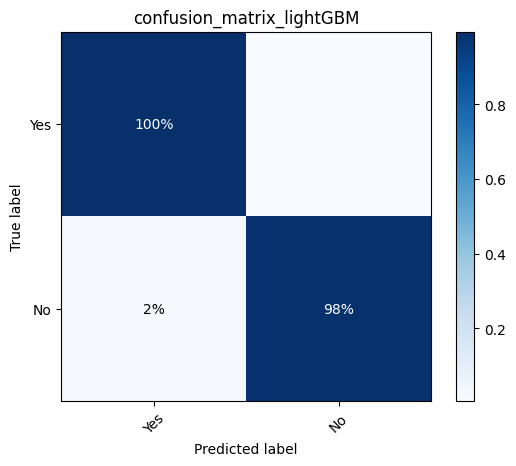

In [98]:
print(metrics.confusion_matrix(df_test['y'], test_labels))
plot_matrix(df_test['y'], test_labels , [0, 1], title='confusion_matrix_lightGBM',
            axis_labels=['Yes', 'No'])

In [29]:
# Initialize CatBoostClassifier
cat_model = CatBoostClassifier(
    eval_metric='AUC',
    learning_rate=0.022,
    iterations=1000,
    verbose=False
)

# Perform cross-validation with StratifiedKFold
catboost_cv_scores = cross_val_score(CatBoostClassifier(), X_kos, y_kos, cv=5, scoring='accuracy')#roc_auc

print("Cross-validation scores:", catboost_cv_scores)
print("Mean AUC:", catboost_cv_scores.mean())

Learning rate set to 0.06048
0:	learn: 0.6455841	total: 181ms	remaining: 3m
1:	learn: 0.5895738	total: 218ms	remaining: 1m 49s
2:	learn: 0.5559827	total: 262ms	remaining: 1m 27s
3:	learn: 0.5301388	total: 306ms	remaining: 1m 16s
4:	learn: 0.5060211	total: 348ms	remaining: 1m 9s
5:	learn: 0.4857934	total: 385ms	remaining: 1m 3s
6:	learn: 0.4679107	total: 434ms	remaining: 1m 1s
7:	learn: 0.4548776	total: 471ms	remaining: 58.4s
8:	learn: 0.4411392	total: 509ms	remaining: 56.1s
9:	learn: 0.4291886	total: 548ms	remaining: 54.3s
10:	learn: 0.4068537	total: 587ms	remaining: 52.8s
11:	learn: 0.3979510	total: 625ms	remaining: 51.5s
12:	learn: 0.3898484	total: 661ms	remaining: 50.2s
13:	learn: 0.3815438	total: 697ms	remaining: 49.1s
14:	learn: 0.3743721	total: 732ms	remaining: 48.1s
15:	learn: 0.3671130	total: 770ms	remaining: 47.4s
16:	learn: 0.3617749	total: 818ms	remaining: 47.3s
17:	learn: 0.3479880	total: 861ms	remaining: 47s
18:	learn: 0.3312091	total: 904ms	remaining: 46.7s
19:	learn: 0.3

165:	learn: 0.1719510	total: 6.76s	remaining: 33.9s
166:	learn: 0.1717903	total: 6.8s	remaining: 33.9s
167:	learn: 0.1713980	total: 6.83s	remaining: 33.9s
168:	learn: 0.1709527	total: 6.88s	remaining: 33.8s
169:	learn: 0.1706231	total: 6.92s	remaining: 33.8s
170:	learn: 0.1704666	total: 6.96s	remaining: 33.7s
171:	learn: 0.1701651	total: 7s	remaining: 33.7s
172:	learn: 0.1699220	total: 7.04s	remaining: 33.7s
173:	learn: 0.1697250	total: 7.08s	remaining: 33.6s
174:	learn: 0.1695877	total: 7.12s	remaining: 33.6s
175:	learn: 0.1689423	total: 7.16s	remaining: 33.5s
176:	learn: 0.1687075	total: 7.2s	remaining: 33.5s
177:	learn: 0.1685851	total: 7.24s	remaining: 33.4s
178:	learn: 0.1683974	total: 7.28s	remaining: 33.4s
179:	learn: 0.1682763	total: 7.32s	remaining: 33.3s
180:	learn: 0.1676639	total: 7.36s	remaining: 33.3s
181:	learn: 0.1670513	total: 7.4s	remaining: 33.3s
182:	learn: 0.1667702	total: 7.44s	remaining: 33.2s
183:	learn: 0.1664717	total: 7.48s	remaining: 33.2s
184:	learn: 0.1658

327:	learn: 0.1290729	total: 13.1s	remaining: 26.8s
328:	learn: 0.1289881	total: 13.1s	remaining: 26.7s
329:	learn: 0.1288148	total: 13.1s	remaining: 26.7s
330:	learn: 0.1286918	total: 13.2s	remaining: 26.6s
331:	learn: 0.1285730	total: 13.2s	remaining: 26.6s
332:	learn: 0.1284732	total: 13.3s	remaining: 26.5s
333:	learn: 0.1281081	total: 13.3s	remaining: 26.5s
334:	learn: 0.1279668	total: 13.3s	remaining: 26.5s
335:	learn: 0.1277925	total: 13.4s	remaining: 26.4s
336:	learn: 0.1277366	total: 13.4s	remaining: 26.4s
337:	learn: 0.1275628	total: 13.4s	remaining: 26.3s
338:	learn: 0.1275116	total: 13.5s	remaining: 26.3s
339:	learn: 0.1273322	total: 13.5s	remaining: 26.2s
340:	learn: 0.1272541	total: 13.6s	remaining: 26.2s
341:	learn: 0.1271882	total: 13.6s	remaining: 26.2s
342:	learn: 0.1271067	total: 13.6s	remaining: 26.1s
343:	learn: 0.1268252	total: 13.7s	remaining: 26.1s
344:	learn: 0.1267722	total: 13.7s	remaining: 26s
345:	learn: 0.1266958	total: 13.8s	remaining: 26s
346:	learn: 0.12

486:	learn: 0.1128894	total: 19s	remaining: 20s
487:	learn: 0.1128437	total: 19.1s	remaining: 20s
488:	learn: 0.1127438	total: 19.1s	remaining: 19.9s
489:	learn: 0.1126617	total: 19.1s	remaining: 19.9s
490:	learn: 0.1125603	total: 19.2s	remaining: 19.9s
491:	learn: 0.1124748	total: 19.2s	remaining: 19.8s
492:	learn: 0.1124252	total: 19.2s	remaining: 19.8s
493:	learn: 0.1123401	total: 19.3s	remaining: 19.7s
494:	learn: 0.1123069	total: 19.3s	remaining: 19.7s
495:	learn: 0.1122189	total: 19.3s	remaining: 19.6s
496:	learn: 0.1121512	total: 19.4s	remaining: 19.6s
497:	learn: 0.1120340	total: 19.4s	remaining: 19.5s
498:	learn: 0.1119271	total: 19.4s	remaining: 19.5s
499:	learn: 0.1118930	total: 19.5s	remaining: 19.5s
500:	learn: 0.1117198	total: 19.5s	remaining: 19.4s
501:	learn: 0.1116527	total: 19.5s	remaining: 19.4s
502:	learn: 0.1115726	total: 19.6s	remaining: 19.3s
503:	learn: 0.1115073	total: 19.6s	remaining: 19.3s
504:	learn: 0.1114615	total: 19.6s	remaining: 19.2s
505:	learn: 0.1113

648:	learn: 0.1032936	total: 25.1s	remaining: 13.6s
649:	learn: 0.1032577	total: 25.2s	remaining: 13.6s
650:	learn: 0.1031978	total: 25.2s	remaining: 13.5s
651:	learn: 0.1031538	total: 25.3s	remaining: 13.5s
652:	learn: 0.1030760	total: 25.3s	remaining: 13.4s
653:	learn: 0.1030394	total: 25.3s	remaining: 13.4s
654:	learn: 0.1030102	total: 25.4s	remaining: 13.4s
655:	learn: 0.1029000	total: 25.4s	remaining: 13.3s
656:	learn: 0.1027890	total: 25.4s	remaining: 13.3s
657:	learn: 0.1027482	total: 25.5s	remaining: 13.2s
658:	learn: 0.1026353	total: 25.5s	remaining: 13.2s
659:	learn: 0.1025981	total: 25.6s	remaining: 13.2s
660:	learn: 0.1025002	total: 25.6s	remaining: 13.1s
661:	learn: 0.1024569	total: 25.6s	remaining: 13.1s
662:	learn: 0.1023957	total: 25.7s	remaining: 13s
663:	learn: 0.1023266	total: 25.7s	remaining: 13s
664:	learn: 0.1022906	total: 25.7s	remaining: 13s
665:	learn: 0.1022329	total: 25.8s	remaining: 12.9s
666:	learn: 0.1021762	total: 25.8s	remaining: 12.9s
667:	learn: 0.1021

807:	learn: 0.0959918	total: 31.3s	remaining: 7.43s
808:	learn: 0.0959389	total: 31.3s	remaining: 7.39s
809:	learn: 0.0958858	total: 31.3s	remaining: 7.35s
810:	learn: 0.0958039	total: 31.4s	remaining: 7.31s
811:	learn: 0.0957902	total: 31.4s	remaining: 7.27s
812:	learn: 0.0957675	total: 31.4s	remaining: 7.23s
813:	learn: 0.0957396	total: 31.5s	remaining: 7.19s
814:	learn: 0.0956949	total: 31.5s	remaining: 7.16s
815:	learn: 0.0956398	total: 31.6s	remaining: 7.12s
816:	learn: 0.0956183	total: 31.6s	remaining: 7.08s
817:	learn: 0.0955932	total: 31.6s	remaining: 7.04s
818:	learn: 0.0955500	total: 31.7s	remaining: 7s
819:	learn: 0.0955141	total: 31.7s	remaining: 6.97s
820:	learn: 0.0954686	total: 31.8s	remaining: 6.93s
821:	learn: 0.0954389	total: 31.8s	remaining: 6.89s
822:	learn: 0.0954062	total: 31.9s	remaining: 6.85s
823:	learn: 0.0953518	total: 31.9s	remaining: 6.81s
824:	learn: 0.0953235	total: 31.9s	remaining: 6.77s
825:	learn: 0.0952553	total: 32s	remaining: 6.74s
826:	learn: 0.095

966:	learn: 0.0897193	total: 37.4s	remaining: 1.27s
967:	learn: 0.0896984	total: 37.4s	remaining: 1.24s
968:	learn: 0.0896551	total: 37.5s	remaining: 1.2s
969:	learn: 0.0895931	total: 37.5s	remaining: 1.16s
970:	learn: 0.0895579	total: 37.5s	remaining: 1.12s
971:	learn: 0.0895112	total: 37.6s	remaining: 1.08s
972:	learn: 0.0894930	total: 37.6s	remaining: 1.04s
973:	learn: 0.0894767	total: 37.7s	remaining: 1s
974:	learn: 0.0894567	total: 37.7s	remaining: 966ms
975:	learn: 0.0894200	total: 37.7s	remaining: 928ms
976:	learn: 0.0893751	total: 37.8s	remaining: 889ms
977:	learn: 0.0893347	total: 37.8s	remaining: 851ms
978:	learn: 0.0892990	total: 37.8s	remaining: 812ms
979:	learn: 0.0892385	total: 37.9s	remaining: 773ms
980:	learn: 0.0892122	total: 37.9s	remaining: 734ms
981:	learn: 0.0891765	total: 38s	remaining: 696ms
982:	learn: 0.0891479	total: 38s	remaining: 657ms
983:	learn: 0.0891154	total: 38s	remaining: 618ms
984:	learn: 0.0891081	total: 38.1s	remaining: 580ms
985:	learn: 0.0890513	

131:	learn: 0.1857625	total: 5.25s	remaining: 34.5s
132:	learn: 0.1855676	total: 5.29s	remaining: 34.5s
133:	learn: 0.1852532	total: 5.33s	remaining: 34.5s
134:	learn: 0.1846963	total: 5.37s	remaining: 34.4s
135:	learn: 0.1843803	total: 5.41s	remaining: 34.4s
136:	learn: 0.1838486	total: 5.45s	remaining: 34.3s
137:	learn: 0.1831853	total: 5.49s	remaining: 34.3s
138:	learn: 0.1827848	total: 5.53s	remaining: 34.2s
139:	learn: 0.1825807	total: 5.57s	remaining: 34.2s
140:	learn: 0.1817591	total: 5.6s	remaining: 34.1s
141:	learn: 0.1813047	total: 5.64s	remaining: 34.1s
142:	learn: 0.1806682	total: 5.68s	remaining: 34.1s
143:	learn: 0.1801887	total: 5.72s	remaining: 34s
144:	learn: 0.1799696	total: 5.76s	remaining: 34s
145:	learn: 0.1794707	total: 5.8s	remaining: 33.9s
146:	learn: 0.1792909	total: 5.84s	remaining: 33.9s
147:	learn: 0.1788251	total: 5.88s	remaining: 33.8s
148:	learn: 0.1785858	total: 5.92s	remaining: 33.8s
149:	learn: 0.1779232	total: 5.96s	remaining: 33.8s
150:	learn: 0.1775

293:	learn: 0.1320535	total: 11.7s	remaining: 28.1s
294:	learn: 0.1319761	total: 11.7s	remaining: 28s
295:	learn: 0.1316697	total: 11.8s	remaining: 28s
296:	learn: 0.1314406	total: 11.8s	remaining: 27.9s
297:	learn: 0.1313320	total: 11.8s	remaining: 27.9s
298:	learn: 0.1312007	total: 11.9s	remaining: 27.8s
299:	learn: 0.1311014	total: 11.9s	remaining: 27.8s
300:	learn: 0.1309553	total: 12s	remaining: 27.8s
301:	learn: 0.1308864	total: 12s	remaining: 27.7s
302:	learn: 0.1308034	total: 12s	remaining: 27.7s
303:	learn: 0.1304164	total: 12.1s	remaining: 27.6s
304:	learn: 0.1303372	total: 12.1s	remaining: 27.6s
305:	learn: 0.1302697	total: 12.1s	remaining: 27.5s
306:	learn: 0.1300848	total: 12.2s	remaining: 27.5s
307:	learn: 0.1299713	total: 12.2s	remaining: 27.5s
308:	learn: 0.1298558	total: 12.3s	remaining: 27.4s
309:	learn: 0.1297837	total: 12.3s	remaining: 27.4s
310:	learn: 0.1297164	total: 12.3s	remaining: 27.3s
311:	learn: 0.1293771	total: 12.4s	remaining: 27.3s
312:	learn: 0.1292662	

452:	learn: 0.1131771	total: 17.9s	remaining: 21.6s
453:	learn: 0.1131442	total: 17.9s	remaining: 21.6s
454:	learn: 0.1130677	total: 18s	remaining: 21.5s
455:	learn: 0.1130304	total: 18s	remaining: 21.5s
456:	learn: 0.1129752	total: 18s	remaining: 21.4s
457:	learn: 0.1129435	total: 18.1s	remaining: 21.4s
458:	learn: 0.1128878	total: 18.1s	remaining: 21.3s
459:	learn: 0.1128390	total: 18.1s	remaining: 21.2s
460:	learn: 0.1127848	total: 18.1s	remaining: 21.2s
461:	learn: 0.1127381	total: 18.1s	remaining: 21.1s
462:	learn: 0.1126809	total: 18.1s	remaining: 21s
463:	learn: 0.1126069	total: 18.2s	remaining: 21s
464:	learn: 0.1125452	total: 18.2s	remaining: 20.9s
465:	learn: 0.1124944	total: 18.2s	remaining: 20.9s
466:	learn: 0.1124533	total: 18.2s	remaining: 20.8s
467:	learn: 0.1123999	total: 18.2s	remaining: 20.7s
468:	learn: 0.1123225	total: 18.2s	remaining: 20.7s
469:	learn: 0.1121681	total: 18.3s	remaining: 20.6s
470:	learn: 0.1120815	total: 18.3s	remaining: 20.5s
471:	learn: 0.1120534	

612:	learn: 0.1038547	total: 23.3s	remaining: 14.7s
613:	learn: 0.1038189	total: 23.3s	remaining: 14.7s
614:	learn: 0.1037945	total: 23.3s	remaining: 14.6s
615:	learn: 0.1037010	total: 23.4s	remaining: 14.6s
616:	learn: 0.1036531	total: 23.4s	remaining: 14.5s
617:	learn: 0.1036116	total: 23.5s	remaining: 14.5s
618:	learn: 0.1035720	total: 23.5s	remaining: 14.5s
619:	learn: 0.1035144	total: 23.5s	remaining: 14.4s
620:	learn: 0.1034700	total: 23.6s	remaining: 14.4s
621:	learn: 0.1034230	total: 23.6s	remaining: 14.4s
622:	learn: 0.1033753	total: 23.7s	remaining: 14.3s
623:	learn: 0.1033332	total: 23.7s	remaining: 14.3s
624:	learn: 0.1033032	total: 23.7s	remaining: 14.2s
625:	learn: 0.1032492	total: 23.8s	remaining: 14.2s
626:	learn: 0.1032063	total: 23.8s	remaining: 14.2s
627:	learn: 0.1031284	total: 23.8s	remaining: 14.1s
628:	learn: 0.1030844	total: 23.9s	remaining: 14.1s
629:	learn: 0.1030615	total: 23.9s	remaining: 14s
630:	learn: 0.1030044	total: 24s	remaining: 14s
631:	learn: 0.1029

774:	learn: 0.0964883	total: 29.5s	remaining: 8.57s
775:	learn: 0.0964116	total: 29.6s	remaining: 8.53s
776:	learn: 0.0963064	total: 29.6s	remaining: 8.49s
777:	learn: 0.0962356	total: 29.6s	remaining: 8.46s
778:	learn: 0.0961309	total: 29.7s	remaining: 8.42s
779:	learn: 0.0960850	total: 29.7s	remaining: 8.38s
780:	learn: 0.0960331	total: 29.8s	remaining: 8.34s
781:	learn: 0.0959546	total: 29.8s	remaining: 8.31s
782:	learn: 0.0959048	total: 29.8s	remaining: 8.27s
783:	learn: 0.0958366	total: 29.9s	remaining: 8.23s
784:	learn: 0.0957754	total: 29.9s	remaining: 8.19s
785:	learn: 0.0957486	total: 29.9s	remaining: 8.15s
786:	learn: 0.0957092	total: 30s	remaining: 8.12s
787:	learn: 0.0956617	total: 30s	remaining: 8.08s
788:	learn: 0.0955920	total: 30.1s	remaining: 8.04s
789:	learn: 0.0955528	total: 30.1s	remaining: 8s
790:	learn: 0.0955268	total: 30.1s	remaining: 7.96s
791:	learn: 0.0954787	total: 30.2s	remaining: 7.92s
792:	learn: 0.0954514	total: 30.2s	remaining: 7.89s
793:	learn: 0.09541

937:	learn: 0.0898292	total: 35.7s	remaining: 2.36s
938:	learn: 0.0897687	total: 35.8s	remaining: 2.32s
939:	learn: 0.0896900	total: 35.8s	remaining: 2.29s
940:	learn: 0.0896345	total: 35.8s	remaining: 2.25s
941:	learn: 0.0896145	total: 35.9s	remaining: 2.21s
942:	learn: 0.0895834	total: 35.9s	remaining: 2.17s
943:	learn: 0.0895644	total: 36s	remaining: 2.13s
944:	learn: 0.0895248	total: 36s	remaining: 2.09s
945:	learn: 0.0894887	total: 36s	remaining: 2.06s
946:	learn: 0.0894669	total: 36.1s	remaining: 2.02s
947:	learn: 0.0894137	total: 36.1s	remaining: 1.98s
948:	learn: 0.0893845	total: 36.1s	remaining: 1.94s
949:	learn: 0.0893555	total: 36.2s	remaining: 1.9s
950:	learn: 0.0892960	total: 36.2s	remaining: 1.86s
951:	learn: 0.0892776	total: 36.3s	remaining: 1.83s
952:	learn: 0.0892384	total: 36.3s	remaining: 1.79s
953:	learn: 0.0892209	total: 36.3s	remaining: 1.75s
954:	learn: 0.0892111	total: 36.4s	remaining: 1.71s
955:	learn: 0.0891683	total: 36.4s	remaining: 1.68s
956:	learn: 0.08913

98:	learn: 0.1993258	total: 3.98s	remaining: 36.2s
99:	learn: 0.1987681	total: 4.02s	remaining: 36.1s
100:	learn: 0.1982744	total: 4.05s	remaining: 36.1s
101:	learn: 0.1978504	total: 4.09s	remaining: 36s
102:	learn: 0.1972397	total: 4.13s	remaining: 36s
103:	learn: 0.1966727	total: 4.17s	remaining: 36s
104:	learn: 0.1963659	total: 4.21s	remaining: 35.9s
105:	learn: 0.1960220	total: 4.25s	remaining: 35.9s
106:	learn: 0.1956054	total: 4.3s	remaining: 35.9s
107:	learn: 0.1940594	total: 4.34s	remaining: 35.9s
108:	learn: 0.1934716	total: 4.38s	remaining: 35.8s
109:	learn: 0.1932729	total: 4.42s	remaining: 35.8s
110:	learn: 0.1930455	total: 4.46s	remaining: 35.7s
111:	learn: 0.1927650	total: 4.5s	remaining: 35.7s
112:	learn: 0.1922927	total: 4.54s	remaining: 35.6s
113:	learn: 0.1919546	total: 4.58s	remaining: 35.6s
114:	learn: 0.1914120	total: 4.62s	remaining: 35.6s
115:	learn: 0.1909261	total: 4.66s	remaining: 35.5s
116:	learn: 0.1900846	total: 4.71s	remaining: 35.5s
117:	learn: 0.1897616	

257:	learn: 0.1397410	total: 10.3s	remaining: 29.6s
258:	learn: 0.1393336	total: 10.3s	remaining: 29.5s
259:	learn: 0.1392483	total: 10.4s	remaining: 29.5s
260:	learn: 0.1390616	total: 10.4s	remaining: 29.4s
261:	learn: 0.1389457	total: 10.4s	remaining: 29.4s
262:	learn: 0.1388290	total: 10.5s	remaining: 29.3s
263:	learn: 0.1387312	total: 10.5s	remaining: 29.2s
264:	learn: 0.1385194	total: 10.5s	remaining: 29.1s
265:	learn: 0.1383163	total: 10.5s	remaining: 29s
266:	learn: 0.1382209	total: 10.5s	remaining: 28.9s
267:	learn: 0.1380818	total: 10.6s	remaining: 28.8s
268:	learn: 0.1377265	total: 10.6s	remaining: 28.7s
269:	learn: 0.1373762	total: 10.6s	remaining: 28.6s
270:	learn: 0.1373004	total: 10.6s	remaining: 28.5s
271:	learn: 0.1370185	total: 10.6s	remaining: 28.4s
272:	learn: 0.1369068	total: 10.6s	remaining: 28.3s
273:	learn: 0.1368059	total: 10.7s	remaining: 28.2s
274:	learn: 0.1366559	total: 10.7s	remaining: 28.1s
275:	learn: 0.1365729	total: 10.7s	remaining: 28s
276:	learn: 0.13

419:	learn: 0.1180536	total: 13.8s	remaining: 19.1s
420:	learn: 0.1180140	total: 13.8s	remaining: 19s
421:	learn: 0.1179243	total: 13.8s	remaining: 19s
422:	learn: 0.1178569	total: 13.9s	remaining: 18.9s
423:	learn: 0.1178106	total: 13.9s	remaining: 18.9s
424:	learn: 0.1177743	total: 13.9s	remaining: 18.8s
425:	learn: 0.1177066	total: 13.9s	remaining: 18.8s
426:	learn: 0.1176372	total: 13.9s	remaining: 18.7s
427:	learn: 0.1175105	total: 14s	remaining: 18.6s
428:	learn: 0.1174018	total: 14s	remaining: 18.6s
429:	learn: 0.1173443	total: 14s	remaining: 18.5s
430:	learn: 0.1172694	total: 14s	remaining: 18.5s
431:	learn: 0.1172307	total: 14s	remaining: 18.4s
432:	learn: 0.1171740	total: 14s	remaining: 18.4s
433:	learn: 0.1170416	total: 14.1s	remaining: 18.3s
434:	learn: 0.1169421	total: 14.1s	remaining: 18.3s
435:	learn: 0.1169054	total: 14.1s	remaining: 18.2s
436:	learn: 0.1168363	total: 14.1s	remaining: 18.2s
437:	learn: 0.1167450	total: 14.1s	remaining: 18.1s
438:	learn: 0.1166962	total:

579:	learn: 0.1069392	total: 18.1s	remaining: 13.1s
580:	learn: 0.1068791	total: 18.1s	remaining: 13.1s
581:	learn: 0.1068396	total: 18.1s	remaining: 13s
582:	learn: 0.1067989	total: 18.2s	remaining: 13s
583:	learn: 0.1067295	total: 18.2s	remaining: 13s
584:	learn: 0.1066742	total: 18.2s	remaining: 12.9s
585:	learn: 0.1066306	total: 18.3s	remaining: 12.9s
586:	learn: 0.1065730	total: 18.3s	remaining: 12.9s
587:	learn: 0.1065231	total: 18.4s	remaining: 12.9s
588:	learn: 0.1064727	total: 18.4s	remaining: 12.8s
589:	learn: 0.1063972	total: 18.4s	remaining: 12.8s
590:	learn: 0.1063319	total: 18.5s	remaining: 12.8s
591:	learn: 0.1063042	total: 18.5s	remaining: 12.8s
592:	learn: 0.1062447	total: 18.5s	remaining: 12.7s
593:	learn: 0.1061808	total: 18.6s	remaining: 12.7s
594:	learn: 0.1061472	total: 18.6s	remaining: 12.7s
595:	learn: 0.1061134	total: 18.7s	remaining: 12.6s
596:	learn: 0.1060614	total: 18.7s	remaining: 12.6s
597:	learn: 0.1059242	total: 18.7s	remaining: 12.6s
598:	learn: 0.1058

742:	learn: 0.0992017	total: 24.4s	remaining: 8.44s
743:	learn: 0.0991268	total: 24.4s	remaining: 8.41s
744:	learn: 0.0990306	total: 24.5s	remaining: 8.38s
745:	learn: 0.0990230	total: 24.5s	remaining: 8.35s
746:	learn: 0.0989721	total: 24.6s	remaining: 8.32s
747:	learn: 0.0989071	total: 24.6s	remaining: 8.29s
748:	learn: 0.0988751	total: 24.6s	remaining: 8.26s
749:	learn: 0.0988346	total: 24.7s	remaining: 8.23s
750:	learn: 0.0987991	total: 24.7s	remaining: 8.2s
751:	learn: 0.0987523	total: 24.8s	remaining: 8.16s
752:	learn: 0.0987095	total: 24.8s	remaining: 8.13s
753:	learn: 0.0986840	total: 24.8s	remaining: 8.1s
754:	learn: 0.0986488	total: 24.9s	remaining: 8.07s
755:	learn: 0.0986041	total: 24.9s	remaining: 8.04s
756:	learn: 0.0985685	total: 24.9s	remaining: 8.01s
757:	learn: 0.0985510	total: 25s	remaining: 7.97s
758:	learn: 0.0985376	total: 25s	remaining: 7.94s
759:	learn: 0.0984937	total: 25s	remaining: 7.91s
760:	learn: 0.0984418	total: 25.1s	remaining: 7.88s
761:	learn: 0.098397

904:	learn: 0.0923518	total: 30.1s	remaining: 3.16s
905:	learn: 0.0922995	total: 30.2s	remaining: 3.13s
906:	learn: 0.0922711	total: 30.2s	remaining: 3.1s
907:	learn: 0.0922112	total: 30.2s	remaining: 3.06s
908:	learn: 0.0921782	total: 30.3s	remaining: 3.03s
909:	learn: 0.0921545	total: 30.3s	remaining: 3s
910:	learn: 0.0920982	total: 30.3s	remaining: 2.96s
911:	learn: 0.0920628	total: 30.4s	remaining: 2.93s
912:	learn: 0.0920481	total: 30.4s	remaining: 2.9s
913:	learn: 0.0920164	total: 30.5s	remaining: 2.87s
914:	learn: 0.0919739	total: 30.5s	remaining: 2.83s
915:	learn: 0.0919681	total: 30.6s	remaining: 2.8s
916:	learn: 0.0919344	total: 30.6s	remaining: 2.77s
917:	learn: 0.0919129	total: 30.6s	remaining: 2.74s
918:	learn: 0.0918754	total: 30.7s	remaining: 2.7s
919:	learn: 0.0918505	total: 30.7s	remaining: 2.67s
920:	learn: 0.0918303	total: 30.8s	remaining: 2.64s
921:	learn: 0.0918068	total: 30.8s	remaining: 2.61s
922:	learn: 0.0917440	total: 30.8s	remaining: 2.57s
923:	learn: 0.09172

65:	learn: 0.2262408	total: 2.77s	remaining: 39.3s
66:	learn: 0.2252572	total: 2.82s	remaining: 39.2s
67:	learn: 0.2236696	total: 2.86s	remaining: 39.2s
68:	learn: 0.2229008	total: 2.9s	remaining: 39.2s
69:	learn: 0.2214974	total: 2.94s	remaining: 39.1s
70:	learn: 0.2210842	total: 2.99s	remaining: 39.1s
71:	learn: 0.2206116	total: 3.03s	remaining: 39.1s
72:	learn: 0.2196899	total: 3.08s	remaining: 39.1s
73:	learn: 0.2190488	total: 3.12s	remaining: 39.1s
74:	learn: 0.2186858	total: 3.17s	remaining: 39.1s
75:	learn: 0.2179796	total: 3.21s	remaining: 39.1s
76:	learn: 0.2173210	total: 3.26s	remaining: 39.1s
77:	learn: 0.2167557	total: 3.3s	remaining: 39s
78:	learn: 0.2160305	total: 3.35s	remaining: 39.1s
79:	learn: 0.2135404	total: 3.4s	remaining: 39.1s
80:	learn: 0.2124516	total: 3.44s	remaining: 39.1s
81:	learn: 0.2119262	total: 3.48s	remaining: 39s
82:	learn: 0.2114135	total: 3.53s	remaining: 39s
83:	learn: 0.2107271	total: 3.57s	remaining: 38.9s
84:	learn: 0.2099651	total: 3.61s	remain

225:	learn: 0.1489166	total: 9.94s	remaining: 34s
226:	learn: 0.1487791	total: 9.98s	remaining: 34s
227:	learn: 0.1486687	total: 10s	remaining: 34s
228:	learn: 0.1485054	total: 10.1s	remaining: 33.9s
229:	learn: 0.1483841	total: 10.1s	remaining: 33.9s
230:	learn: 0.1482730	total: 10.2s	remaining: 33.8s
231:	learn: 0.1480145	total: 10.2s	remaining: 33.8s
232:	learn: 0.1474816	total: 10.2s	remaining: 33.7s
233:	learn: 0.1473556	total: 10.3s	remaining: 33.7s
234:	learn: 0.1471672	total: 10.3s	remaining: 33.6s
235:	learn: 0.1470404	total: 10.4s	remaining: 33.6s
236:	learn: 0.1469590	total: 10.4s	remaining: 33.5s
237:	learn: 0.1468642	total: 10.5s	remaining: 33.5s
238:	learn: 0.1466447	total: 10.5s	remaining: 33.5s
239:	learn: 0.1464635	total: 10.5s	remaining: 33.4s
240:	learn: 0.1462242	total: 10.6s	remaining: 33.4s
241:	learn: 0.1458686	total: 10.6s	remaining: 33.3s
242:	learn: 0.1457763	total: 10.7s	remaining: 33.3s
243:	learn: 0.1456772	total: 10.7s	remaining: 33.2s
244:	learn: 0.145422

388:	learn: 0.1226729	total: 16.3s	remaining: 25.5s
389:	learn: 0.1226012	total: 16.3s	remaining: 25.5s
390:	learn: 0.1225162	total: 16.3s	remaining: 25.4s
391:	learn: 0.1224292	total: 16.4s	remaining: 25.4s
392:	learn: 0.1223713	total: 16.4s	remaining: 25.4s
393:	learn: 0.1222925	total: 16.5s	remaining: 25.3s
394:	learn: 0.1221350	total: 16.5s	remaining: 25.3s
395:	learn: 0.1217422	total: 16.6s	remaining: 25.3s
396:	learn: 0.1217027	total: 16.6s	remaining: 25.2s
397:	learn: 0.1216205	total: 16.6s	remaining: 25.2s
398:	learn: 0.1215823	total: 16.7s	remaining: 25.1s
399:	learn: 0.1215159	total: 16.7s	remaining: 25.1s
400:	learn: 0.1214555	total: 16.7s	remaining: 25s
401:	learn: 0.1213724	total: 16.8s	remaining: 25s
402:	learn: 0.1212852	total: 16.8s	remaining: 24.9s
403:	learn: 0.1212127	total: 16.9s	remaining: 24.9s
404:	learn: 0.1211494	total: 16.9s	remaining: 24.8s
405:	learn: 0.1211083	total: 16.9s	remaining: 24.8s
406:	learn: 0.1210389	total: 17s	remaining: 24.7s
407:	learn: 0.1209

551:	learn: 0.1092852	total: 22.6s	remaining: 18.3s
552:	learn: 0.1091932	total: 22.6s	remaining: 18.3s
553:	learn: 0.1091537	total: 22.7s	remaining: 18.2s
554:	learn: 0.1090820	total: 22.7s	remaining: 18.2s
555:	learn: 0.1090252	total: 22.7s	remaining: 18.2s
556:	learn: 0.1089781	total: 22.8s	remaining: 18.1s
557:	learn: 0.1088221	total: 22.8s	remaining: 18.1s
558:	learn: 0.1087484	total: 22.8s	remaining: 18s
559:	learn: 0.1087139	total: 22.9s	remaining: 18s
560:	learn: 0.1086690	total: 22.9s	remaining: 17.9s
561:	learn: 0.1085668	total: 22.9s	remaining: 17.9s
562:	learn: 0.1084298	total: 23s	remaining: 17.8s
563:	learn: 0.1083615	total: 23s	remaining: 17.8s
564:	learn: 0.1082941	total: 23.1s	remaining: 17.8s
565:	learn: 0.1082442	total: 23.1s	remaining: 17.7s
566:	learn: 0.1081624	total: 23.1s	remaining: 17.7s
567:	learn: 0.1081120	total: 23.2s	remaining: 17.6s
568:	learn: 0.1079807	total: 23.2s	remaining: 17.6s
569:	learn: 0.1078700	total: 23.2s	remaining: 17.5s
570:	learn: 0.107798

712:	learn: 0.1000123	total: 28s	remaining: 11.3s
713:	learn: 0.0999833	total: 28.1s	remaining: 11.2s
714:	learn: 0.0999206	total: 28.1s	remaining: 11.2s
715:	learn: 0.0998781	total: 28.1s	remaining: 11.2s
716:	learn: 0.0998426	total: 28.2s	remaining: 11.1s
717:	learn: 0.0997741	total: 28.2s	remaining: 11.1s
718:	learn: 0.0996768	total: 28.2s	remaining: 11s
719:	learn: 0.0996291	total: 28.3s	remaining: 11s
720:	learn: 0.0995527	total: 28.3s	remaining: 11s
721:	learn: 0.0995205	total: 28.3s	remaining: 10.9s
722:	learn: 0.0994827	total: 28.4s	remaining: 10.9s
723:	learn: 0.0994519	total: 28.4s	remaining: 10.8s
724:	learn: 0.0994028	total: 28.4s	remaining: 10.8s
725:	learn: 0.0993595	total: 28.5s	remaining: 10.7s
726:	learn: 0.0993299	total: 28.5s	remaining: 10.7s
727:	learn: 0.0992842	total: 28.5s	remaining: 10.7s
728:	learn: 0.0992587	total: 28.6s	remaining: 10.6s
729:	learn: 0.0992140	total: 28.6s	remaining: 10.6s
730:	learn: 0.0991869	total: 28.6s	remaining: 10.5s
731:	learn: 0.099146

871:	learn: 0.0932119	total: 33.1s	remaining: 4.85s
872:	learn: 0.0931785	total: 33.1s	remaining: 4.81s
873:	learn: 0.0931472	total: 33.1s	remaining: 4.77s
874:	learn: 0.0931166	total: 33.1s	remaining: 4.74s
875:	learn: 0.0930963	total: 33.2s	remaining: 4.7s
876:	learn: 0.0930547	total: 33.2s	remaining: 4.66s
877:	learn: 0.0929871	total: 33.2s	remaining: 4.62s
878:	learn: 0.0929290	total: 33.3s	remaining: 4.58s
879:	learn: 0.0929137	total: 33.3s	remaining: 4.54s
880:	learn: 0.0928928	total: 33.4s	remaining: 4.5s
881:	learn: 0.0928536	total: 33.4s	remaining: 4.47s
882:	learn: 0.0928090	total: 33.4s	remaining: 4.43s
883:	learn: 0.0927747	total: 33.5s	remaining: 4.39s
884:	learn: 0.0927352	total: 33.5s	remaining: 4.35s
885:	learn: 0.0926805	total: 33.5s	remaining: 4.31s
886:	learn: 0.0925886	total: 33.6s	remaining: 4.28s
887:	learn: 0.0925232	total: 33.6s	remaining: 4.24s
888:	learn: 0.0924863	total: 33.6s	remaining: 4.2s
889:	learn: 0.0924396	total: 33.7s	remaining: 4.16s
890:	learn: 0.0

33:	learn: 0.2805116	total: 1.54s	remaining: 43.9s
34:	learn: 0.2724551	total: 1.59s	remaining: 43.7s
35:	learn: 0.2712724	total: 1.63s	remaining: 43.6s
36:	learn: 0.2700291	total: 1.67s	remaining: 43.3s
37:	learn: 0.2666505	total: 1.7s	remaining: 42.9s
38:	learn: 0.2650649	total: 1.73s	remaining: 42.5s
39:	learn: 0.2595287	total: 1.75s	remaining: 42.1s
40:	learn: 0.2581595	total: 1.79s	remaining: 41.8s
41:	learn: 0.2566849	total: 1.82s	remaining: 41.6s
42:	learn: 0.2521504	total: 1.87s	remaining: 41.6s
43:	learn: 0.2507342	total: 1.91s	remaining: 41.5s
44:	learn: 0.2497822	total: 1.95s	remaining: 41.4s
45:	learn: 0.2482820	total: 2s	remaining: 41.4s
46:	learn: 0.2474631	total: 2.04s	remaining: 41.3s
47:	learn: 0.2463238	total: 2.08s	remaining: 41.2s
48:	learn: 0.2451594	total: 2.11s	remaining: 41s
49:	learn: 0.2440746	total: 2.17s	remaining: 41.3s
50:	learn: 0.2420451	total: 2.2s	remaining: 41s
51:	learn: 0.2413126	total: 2.23s	remaining: 40.8s
52:	learn: 0.2400302	total: 2.29s	remain

200:	learn: 0.1564216	total: 6.42s	remaining: 25.5s
201:	learn: 0.1561081	total: 6.45s	remaining: 25.5s
202:	learn: 0.1558162	total: 6.46s	remaining: 25.4s
203:	learn: 0.1555535	total: 6.48s	remaining: 25.3s
204:	learn: 0.1553253	total: 6.5s	remaining: 25.2s
205:	learn: 0.1551283	total: 6.52s	remaining: 25.1s
206:	learn: 0.1549188	total: 6.55s	remaining: 25.1s
207:	learn: 0.1547781	total: 6.57s	remaining: 25s
208:	learn: 0.1546699	total: 6.59s	remaining: 24.9s
209:	learn: 0.1545049	total: 6.61s	remaining: 24.9s
210:	learn: 0.1541428	total: 6.63s	remaining: 24.8s
211:	learn: 0.1539770	total: 6.64s	remaining: 24.7s
212:	learn: 0.1532816	total: 6.67s	remaining: 24.6s
213:	learn: 0.1531591	total: 6.68s	remaining: 24.6s
214:	learn: 0.1524651	total: 6.71s	remaining: 24.5s
215:	learn: 0.1522701	total: 6.73s	remaining: 24.4s
216:	learn: 0.1517152	total: 6.75s	remaining: 24.3s
217:	learn: 0.1515752	total: 6.77s	remaining: 24.3s
218:	learn: 0.1514360	total: 6.79s	remaining: 24.2s
219:	learn: 0.1

369:	learn: 0.1227816	total: 9.88s	remaining: 16.8s
370:	learn: 0.1227236	total: 9.9s	remaining: 16.8s
371:	learn: 0.1226492	total: 9.92s	remaining: 16.7s
372:	learn: 0.1226042	total: 9.94s	remaining: 16.7s
373:	learn: 0.1225258	total: 9.95s	remaining: 16.7s
374:	learn: 0.1224694	total: 9.97s	remaining: 16.6s
375:	learn: 0.1224118	total: 9.99s	remaining: 16.6s
376:	learn: 0.1223657	total: 10s	remaining: 16.5s
377:	learn: 0.1223152	total: 10s	remaining: 16.5s
378:	learn: 0.1222483	total: 10s	remaining: 16.5s
379:	learn: 0.1221829	total: 10.1s	remaining: 16.4s
380:	learn: 0.1221367	total: 10.1s	remaining: 16.4s
381:	learn: 0.1220225	total: 10.1s	remaining: 16.3s
382:	learn: 0.1218160	total: 10.1s	remaining: 16.3s
383:	learn: 0.1216400	total: 10.1s	remaining: 16.3s
384:	learn: 0.1214908	total: 10.2s	remaining: 16.2s
385:	learn: 0.1213771	total: 10.2s	remaining: 16.2s
386:	learn: 0.1213162	total: 10.2s	remaining: 16.2s
387:	learn: 0.1211719	total: 10.2s	remaining: 16.1s
388:	learn: 0.12110

529:	learn: 0.1093877	total: 13s	remaining: 11.5s
530:	learn: 0.1093344	total: 13s	remaining: 11.5s
531:	learn: 0.1093048	total: 13s	remaining: 11.5s
532:	learn: 0.1092676	total: 13.1s	remaining: 11.4s
533:	learn: 0.1092174	total: 13.1s	remaining: 11.4s
534:	learn: 0.1091797	total: 13.1s	remaining: 11.4s
535:	learn: 0.1091461	total: 13.2s	remaining: 11.4s
536:	learn: 0.1091012	total: 13.2s	remaining: 11.4s
537:	learn: 0.1090526	total: 13.2s	remaining: 11.4s
538:	learn: 0.1089976	total: 13.3s	remaining: 11.4s
539:	learn: 0.1089612	total: 13.3s	remaining: 11.3s
540:	learn: 0.1088915	total: 13.4s	remaining: 11.3s
541:	learn: 0.1088067	total: 13.4s	remaining: 11.3s
542:	learn: 0.1086982	total: 13.4s	remaining: 11.3s
543:	learn: 0.1086396	total: 13.5s	remaining: 11.3s
544:	learn: 0.1085729	total: 13.5s	remaining: 11.3s
545:	learn: 0.1085375	total: 13.6s	remaining: 11.3s
546:	learn: 0.1085069	total: 13.6s	remaining: 11.3s
547:	learn: 0.1084634	total: 13.6s	remaining: 11.2s
548:	learn: 0.1083

691:	learn: 0.1012115	total: 19.1s	remaining: 8.51s
692:	learn: 0.1011192	total: 19.2s	remaining: 8.48s
693:	learn: 0.1010729	total: 19.2s	remaining: 8.46s
694:	learn: 0.1009435	total: 19.2s	remaining: 8.44s
695:	learn: 0.1008444	total: 19.3s	remaining: 8.42s
696:	learn: 0.1008087	total: 19.3s	remaining: 8.39s
697:	learn: 0.1006817	total: 19.3s	remaining: 8.37s
698:	learn: 0.1005706	total: 19.4s	remaining: 8.35s
699:	learn: 0.1005030	total: 19.4s	remaining: 8.32s
700:	learn: 0.1004766	total: 19.5s	remaining: 8.3s
701:	learn: 0.1004183	total: 19.5s	remaining: 8.27s
702:	learn: 0.1003576	total: 19.5s	remaining: 8.25s
703:	learn: 0.1002677	total: 19.6s	remaining: 8.22s
704:	learn: 0.1002269	total: 19.6s	remaining: 8.2s
705:	learn: 0.1001918	total: 19.6s	remaining: 8.17s
706:	learn: 0.1001514	total: 19.7s	remaining: 8.15s
707:	learn: 0.1000904	total: 19.7s	remaining: 8.12s
708:	learn: 0.1000443	total: 19.7s	remaining: 8.1s
709:	learn: 0.0999946	total: 19.8s	remaining: 8.07s
710:	learn: 0.0

855:	learn: 0.0936519	total: 25.3s	remaining: 4.25s
856:	learn: 0.0936168	total: 25.3s	remaining: 4.22s
857:	learn: 0.0935871	total: 25.3s	remaining: 4.19s
858:	learn: 0.0935699	total: 25.4s	remaining: 4.17s
859:	learn: 0.0935282	total: 25.4s	remaining: 4.14s
860:	learn: 0.0934893	total: 25.4s	remaining: 4.11s
861:	learn: 0.0934450	total: 25.5s	remaining: 4.08s
862:	learn: 0.0934019	total: 25.5s	remaining: 4.05s
863:	learn: 0.0933621	total: 25.6s	remaining: 4.02s
864:	learn: 0.0933193	total: 25.6s	remaining: 4s
865:	learn: 0.0932928	total: 25.6s	remaining: 3.97s
866:	learn: 0.0932448	total: 25.7s	remaining: 3.94s
867:	learn: 0.0932073	total: 25.7s	remaining: 3.91s
868:	learn: 0.0931797	total: 25.8s	remaining: 3.88s
869:	learn: 0.0931340	total: 25.8s	remaining: 3.85s
870:	learn: 0.0930922	total: 25.8s	remaining: 3.83s
871:	learn: 0.0930616	total: 25.9s	remaining: 3.8s
872:	learn: 0.0930337	total: 25.9s	remaining: 3.77s
873:	learn: 0.0930013	total: 25.9s	remaining: 3.74s
874:	learn: 0.09

In [30]:
#Cat_features
cat_features = np.where(X.dtypes != np.float64)[0]

# Train the model on the entire dataset
train_pool = Pool(X_kos, y_kos, cat_features=cat_features)
cat_model.fit(train_pool)

# Make predictions on the test set
test_pool = Pool(df_test[feat_cols], cat_features=cat_features)
test_predictions = cat_model.predict_proba(test_pool)[:, 1]
test_labels = [i >= 0.5 for i in test_predictions]
metrics.confusion_matrix(df_test['y'], test_labels)

array([[3768,  232],
       [ 158,  363]], dtype=int64)

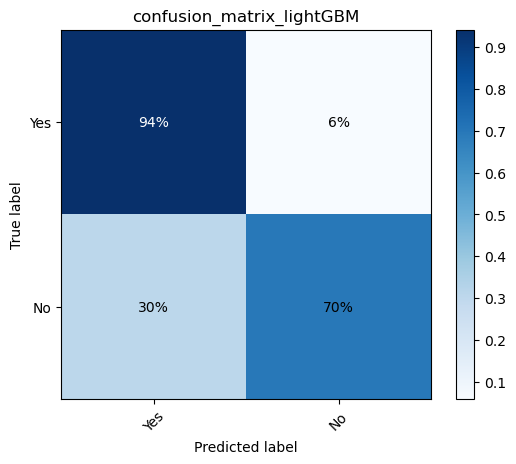

In [31]:
plot_matrix(df_test['y'], test_labels , [0, 1], title='confusion_matrix_lightGBM',
            axis_labels=['Yes', 'No'])

In [32]:
# XGBoost Parameters
xgb_params = {
    'max_depth': 6,
    'learning_rate': 0.01,
    'n_estimators': 1000,
    'min_child_weight': 1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'gamma': 0,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'use_label_encoder': False,
    'nthread': -1,
    'random_state': 42
}

# Initialize XGBoost Classifier
xgb_model = xgb.XGBClassifier(**xgb_params)

# Perform cross-validation with StratifiedKFold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
xgb_cv_scores = cross_val_score(xgb_model, X_kos, y_kos, cv=cv, scoring='accuracy')#roc_auc



print("Cross-validation scores:", xgb_cv_scores)
print("Mean AUC:", xgb_cv_scores.mean())

Cross-validation scores: [0.93555541 0.93175337 0.92705957 0.92991128 0.92927757]
Mean AUC: 0.930711440953244


In [33]:
# Train the model on the entire dataset
xgb_model.fit(X_kos, y_kos)

# Make predictions on the test set
test_predictions = xgb_model.predict_proba(df_test[feat_cols])[:, 1]
test_labels = [i >= 0.5 for i in test_predictions]
metrics.confusion_matrix(df_test['y'], test_labels)

array([[3652,  348],
       [ 118,  403]], dtype=int64)

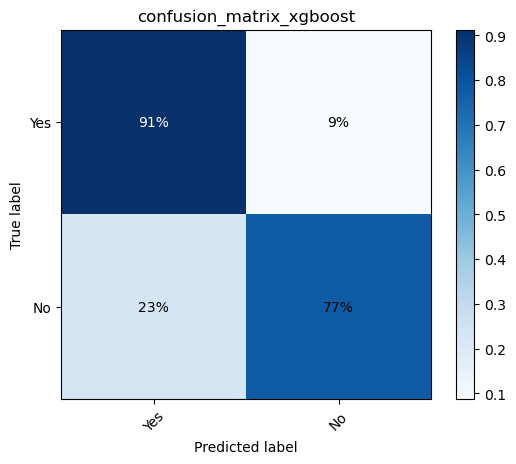

In [34]:
plot_matrix(df_test['y'], test_labels , [0, 1], title='confusion_matrix_xgboost',
            axis_labels=['Yes', 'No'])

In [35]:
# Random Forest
rf = RandomForestClassifier(n_estimators = 100)
rf_cv_scores = cross_val_score(rf, X_kos, y_kos, cv=5, scoring='accuracy')#roc_auc

print("Cross-validation scores:", rf_cv_scores)
print("Mean AUC:", rf_cv_scores.mean())

Cross-validation scores: [0.94841898 0.94841898 0.94885932 0.94727503 0.94790875]
Mean AUC: 0.9481762124465181


In [36]:
# Train the model on the entire dataset
rf.fit(X_kos, y_kos)

# Make predictions on the test set
test_predictions = rf.predict_proba(df_test[feat_cols])[:, 1]
test_labels = [i >= 0.5 for i in test_predictions]
metrics.confusion_matrix(df_test['y'], test_labels)

array([[3978,   22],
       [   2,  519]], dtype=int64)

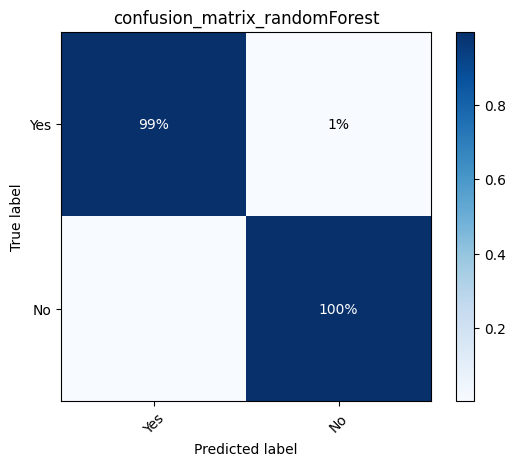

In [37]:
plot_matrix(df_test['y'], test_labels , [0, 1], title='confusion_matrix_randomForest',
            axis_labels=['Yes', 'No'])

Text(0.5, 1.0, 'Var Importance')

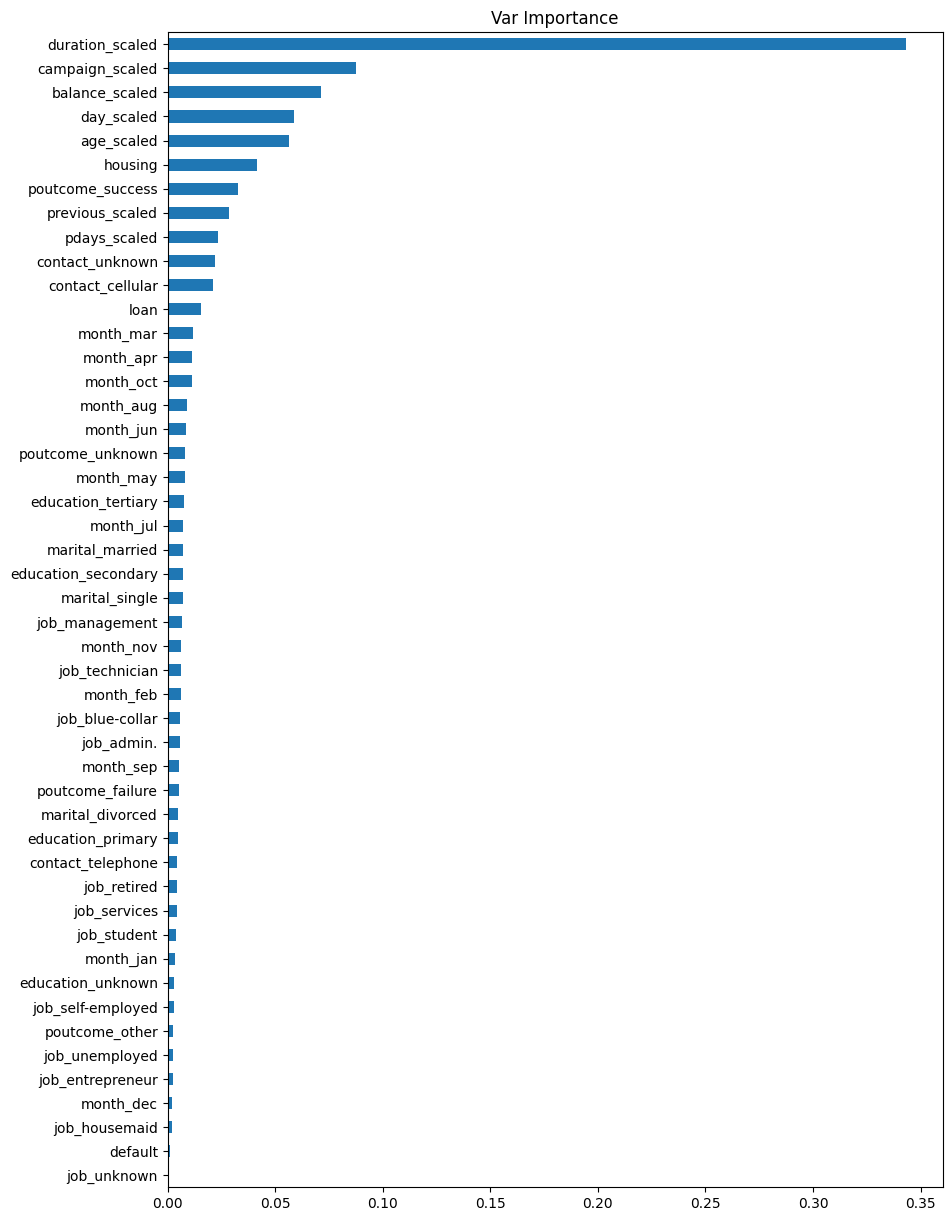

In [39]:
importance_rf = pd.Series(rf.feature_importances_.flatten(), index = X_kos.columns, name = 'Var')
importance_rf.sort_values().plot(kind = 'barh',figsize= (10, 15))

plt.title('Var Importance')

In [46]:
classifiers = ['LightGBM', 'CatBoost', 'XGBoost','RandomForest']
auc_scores = [lgb_cv_scores.mean(), catboost_cv_scores.mean(), xgb_cv_scores.mean(),rf_cv_scores.mean()]

NameError: name 'catboost_cv_scores' is not defined

In [ ]:
# Create data for the plot
colors = ['#4e79a7', '#f28e2b', '#e15759','#008000']

# Create the figure with optimized settings
fig = go.Figure(data=[go.Bar(
    x=classifiers,
    y=[i for i in auc_scores],
    name='Accuracy',
    marker_color=colors
)])

# Update layout with optimized settings
fig.update_layout(
    title='AUC Comparison',
    xaxis_title='Classifier',
    yaxis_title='AUC Score',
    template='plotly_white',
    font=dict(family="Arial", size=12),
    width=600,
    margin=dict(l=50, r=50, t=50, b=50)
)

# Add gridlines
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='#E0E0E0')

# Show the plot
fig.show()

In [ ]:
# Selcting Best and Highest AUC_Score  from Above trained Models 

# Find the index of the maximum AUc_Score
best_accuracy_index = auc_scores.index(max(auc_scores))

# Print the best model for accuracy
print(f'Best Accuracy: {auc_scores[best_accuracy_index]:.4f} with Model: {classifiers[best_accuracy_index]}')